# 03_preprocessing_and_modelling_realized_volatility_capstone_project

## Key Objectives 

1) Develop features based on stock data in the book and trade files.

2) Create a class for pre-processing raw data across all stocks into a single features dataframe.

3) Train a model on the features dataframe, using a part of the data as the validation set.

4) Tune the hyperparameters of the model to improve its performance on the validation set.

5) Finally, use the tuned model to make predictions on test set and evaluate its performance. 



In [1]:
import os
import pandas as pd
import numpy as np
import glob
from sb_utils import save_file
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import statsmodels.api as sm
from scipy.stats import norm
import pylab

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import kstest, norm

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from patsy import dmatrices

import time
import warnings
warnings.filterwarnings('ignore')


In [2]:
import tensorflow as tf
from tensorflow.keras import Model, Input
import keras
from keras.layers import Dense, Embedding, Concatenate, Flatten
from keras.models import Sequential
from keras.layers import LeakyReLU
import keras.backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import optimizers
import xgboost as xgb
import lightgbm as lgb

def set_seed_and_configure_tf_session(seed_value=23):
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.compat.v1.set_random_seed(seed_value)

    # Configure a new global `tensorflow` session
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

set_seed_and_configure_tf_session()

# custom loss function in tensorflow
def keras_rmspe(y_true, y_pred):
    
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))

def get_model_lrelu(no_of_features, neurons, alphas=[0.3,0.3]):
    # function to generate sequential keras model with leakyrelu activation function
    
    new_model = Sequential()
    new_model.add(Dense(neurons[0], activation=LeakyReLU(alpha=alphas[0]), input_shape=(no_of_features,)))
    
    for idx, units in enumerate(neurons):
        if idx > 0:
            new_model.add(Dense(units, activation=LeakyReLU(alpha=alphas[idx])))
    
    new_model.add(Dense(1))
    
    return new_model


## 1.0 Key Functions

Define important functions required for feature building and preprocessing.

### 1.1 General Functions

In [3]:

def log_return(list_stock_prices):
    # calculate the log return of a price series
    
    return np.log(list_stock_prices).diff()

def realized_volatility(series_log_return):
    # calculate the realized volatility using a series of log return for a stock
    
    return np.sqrt(np.sum(series_log_return**2))

def high_low_index(price_series):
    # Calculate the value of highest price divided by lowest price for a time bucket
    
    return ((np.max(price_series) / np.min(price_series)))

def close_open_index(price_series):
    # Calculate the value of closing price divided by opening price for a time bucket
    
    return ((price_series.values[-1] / price_series.values[0]))

def count_non_zeros(series):
    return np.count_nonzero(series)

def rmspe(y_true, y_pred):
    # Calculate the root mean squared percentage error. This is an evaluation criteria defined by Optiver.
    
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))


### 1.2 Functions to create book features

In [116]:

def book_params(df_book):
    ## calculate key parameters for book
  
    df_book['wap_1'] = (df_book.bid_price1*df_book.ask_size1 + df_book.ask_price1*df_book.bid_size1) \
                        /(df_book.ask_size1 + df_book.bid_size1)
    df_book['wap_2'] = (df_book.bid_price2*df_book.ask_size2 + df_book.ask_price2*df_book.bid_size2) \
                        /(df_book.ask_size2 + df_book.bid_size2)
    
    df_book['wap_diff'] = df_book['wap_1'] - df_book['wap_2']
    df_book['wap_diff_absolute'] = np.abs(df_book['wap_diff'])
    df_book['size_imbalance'] = (df_book.ask_size1 + df_book.ask_size2) - (df_book.bid_size1 + df_book.bid_size2)
    df_book['size_imbalance_abs'] = np.abs(df_book['size_imbalance'])

    df_book['value_imbalance'] = (df_book.ask_price1*df_book.ask_size1 + df_book.ask_price2*df_book.ask_size2) - \
                                (df_book.bid_price1*df_book.bid_size1 + df_book.bid_price2*df_book.bid_size2)
    df_book['value_imbalance_abs'] = np.abs(df_book['value_imbalance'])
   
    df_book['log_return_1'] = df_book.groupby(['time_id'])['wap_1'].apply(log_return)
    df_book['log_return_2'] = df_book.groupby(['time_id'])['wap_2'].apply(log_return)
    
    df_book['spread_1'] = (df_book.ask_price1 / df_book.bid_price1 ) - 1.0
    df_book['spread_2'] = (df_book.ask_price2 / df_book.bid_price2 ) - 1.0
        
    df_book['speed_wap1'] = df_book.groupby('time_id')['wap_1'].diff()
    df_book['speed_wap1'] = df_book['speed_wap1'].fillna(0.0)
    df_book['acceleration_wap1'] = np.abs(df_book.groupby('time_id')['speed_wap1'].diff())
    df_book['speed_wap1'] = np.abs(df_book['speed_wap1'])
    df_book['acceleration_wap1'] = df_book['acceleration_wap1'].fillna(0.0)
    df_book['momentum_book'] = (df_book.ask_size1 + df_book.ask_size2 + df_book.bid_size1+ df_book.bid_size2) *\
                            df_book['speed_wap1']
    df_book['log_momentum_book'] = (df_book.ask_size1 + df_book.ask_size2 + df_book.bid_size1+ df_book.bid_size2) *\
                            df_book['log_return_1']
    
    df_book['force_book'] = (df_book.ask_size1 + df_book.ask_size2 + df_book.bid_size1+ df_book.bid_size2) *\
                            df_book['acceleration_wap1']
    df_book['log_force_book'] = (df_book.ask_size1 + df_book.ask_size2 + df_book.bid_size1+ df_book.bid_size2) *\
                            (df_book['log_return_1']**2.0) / 2.0
        
    df_book = df_book[~df_book['log_return_1'].isnull()]
        
    return df_book

def features_from_book(df_book):
    ## build book features using book parameters
    
    ## wap features
    book_features = pd.DataFrame(df_book.groupby(['stock_id','time_id'])['wap_1'].agg([np.mean, np.std, \
                                                                    high_low_index])).reset_index()
    book_features = book_features.rename(columns = {'high_low_index': 'wap1_hl_index', 'mean': 'wap1_mean', \
                                                    'std': 'wap1_std'})  
    wap2_features = pd.DataFrame(df_book.groupby(['time_id'])['wap_2'].agg([np.mean, np.std, \
                                                                    high_low_index])).reset_index()
    wap2_features = wap2_features.rename(columns = {'high_low_index': 'wap2_hl_index', 'mean': 'wap2_mean', \
                                                    'std': 'wap2_std'})  
    wap_diff_features = pd.DataFrame(df_book.groupby(['time_id'])['wap_diff'].agg([np.mean, np.std])).reset_index()
    wap_diff_features = wap_diff_features.rename(columns = {'mean': 'wap_diff_mean', 'std': 'wap_diff_std'})
    book_features = book_features.merge(wap2_features, on='time_id', how='left').merge(wap_diff_features, on='time_id', how='left')

    # size features
    bidsize_features = pd.DataFrame(df_book.groupby(['time_id'])['bid_size1'].agg([np.mean, np.std])).reset_index()
    bidsize_features = bidsize_features.rename(columns = {'mean': 'bid_size1_mean', 'std': 'bid_size1_std'})
    asksize_features = pd.DataFrame(df_book.groupby(['time_id'])['ask_size1'].agg([np.mean, np.std])).reset_index()
    asksize_features = asksize_features.rename(columns = {'mean': 'ask_size1_mean', 'std': 'ask_size1_std'})
    book_features = book_features.merge(bidsize_features, on='time_id', how='left').merge(asksize_features, on='time_id', how='left')
    
    ## spread features
    spread1_features = pd.DataFrame(df_book.groupby(['time_id'])['spread_1'].agg([np.sum, np.std])).reset_index()
    spread1_features = spread1_features.rename(columns = {'sum': 'spread_1_sum', 'std': 'spread_1_std'})
    spread2_features = pd.DataFrame(df_book.groupby(['time_id'])['spread_2'].agg([np.sum, np.std])).reset_index()
    spread2_features = spread2_features.rename(columns = {'sum': 'spread_2_sum', 'std': 'spread_2_std'})
    book_features = book_features.merge(spread1_features, on='time_id', how='left').merge(spread2_features, on='time_id', how='left')
    
    ## speed & acceleration features
    speed_features = pd.DataFrame(df_book.groupby(['time_id'])['speed_wap1'].agg([np.sum,np.std])).reset_index()
    speed_features = speed_features.rename(columns = {'sum': 'speed_wap1_sum', 'std': 'speed_wap1_std'})
    acceleration_features = pd.DataFrame(df_book.groupby(['time_id'])['acceleration_wap1'].agg([np.sum, np.std])).reset_index()
    acceleration_features = acceleration_features.rename(columns = {'sum': 'acceleration_wap1_sum', \
                                                        'std': 'acceleration_wap1_std'})
    book_features = book_features.merge(speed_features, on='time_id', how='left').merge(acceleration_features, \
                                                                                        on='time_id', how='left')
    ## momentum & force features
    momentum_features = pd.DataFrame(df_book.groupby(['time_id'])['momentum_book'].agg([np.sum,np.std])).reset_index()
    momentum_features = momentum_features.rename(columns = {'sum': 'momentum_book_sum', 'std': 'momentum_book_std'})
    force_features = pd.DataFrame(df_book.groupby(['time_id'])['force_book'].agg([np.sum, np.std])).reset_index()
    force_features = force_features.rename(columns = {'sum': 'force_book_sum', 'std': 'force_book_std'})
    book_features = book_features.merge(momentum_features, on='time_id', how='left').merge(force_features, \
                                                                                        on='time_id', how='left')
    logmomentum_features = pd.DataFrame(df_book.groupby(['time_id'])['log_momentum_book'].agg([np.sum,np.std])).reset_index()
    logmomentum_features = logmomentum_features.rename(columns = {'sum': 'log_momentum_book_sum', \
                                                                  'std': 'log_momentum_book_std'})
    logforce_features = pd.DataFrame(df_book.groupby(['time_id'])['log_force_book'].agg([np.sum, np.std])).reset_index()
    logforce_features = logforce_features.rename(columns = {'sum': 'log_force_book_sum', 'std': 'log_force_book_std'})
    book_features = book_features.merge(logmomentum_features, on='time_id', how='left').merge(logforce_features, \
                                                                                        on='time_id', how='left')

    ## volatility features
    book_vol_1 = pd.DataFrame(df_book.groupby('time_id')['log_return_1'].agg(realized_volatility)).reset_index()
    book_vol_1 = book_vol_1.rename(columns = {'log_return_1': "realized_vol_wap1"})
    book_vol_2 = pd.DataFrame(df_book.groupby('time_id')['log_return_2'].agg(realized_volatility)).reset_index()
    book_vol_2 = book_vol_2.rename(columns = {'log_return_2': "realized_vol_wap2"})
    book_features = book_features.merge(book_vol_1, on='time_id', how='left').merge(book_vol_2, on='time_id', how='left')
    
    ## seconds active
    seconds_active = pd.DataFrame(df_book.groupby('time_id')['log_return_1'].apply(count_non_zeros)).reset_index()
    seconds_active = seconds_active.rename(columns = {'log_return_1': "seconds_active_book"})
    book_features = book_features.merge(seconds_active, on='time_id', how='left')

    ## book features for time_splits within the 10-minutes of available data
    # features for 5-min halves
    second_limits = [299, 599]
    
    for idx, limit in enumerate(second_limits):
        if idx == 0:
            df_temp = df_book[df_book["seconds_in_bucket"] <= limit ]
        else:
            df_temp = df_book[(df_book["seconds_in_bucket"] > second_limits[idx-1]) & \
                                  (df_book["seconds_in_bucket"] <= limit)]
            
        acc_features = pd.DataFrame(df_temp.groupby(['time_id'])['acceleration_wap1'].agg([np.sum, np.std])).reset_index()
        acc_features = acc_features.rename(columns = {'sum': f'acceleration_wap1_sum_H{idx+1}', \
                                                        'std': f'acceleration_wap1_std_H{idx+1}'})
        vol_features = pd.DataFrame(df_temp.groupby(['time_id'])['log_return_1'].agg(realized_volatility)).reset_index()
        vol_features = vol_features.rename(columns = {'log_return_1': f"realized_vol_wap1_H{idx+1}"})
        book_features = book_features.merge(acc_features, on='time_id', how='left').merge(vol_features, on='time_id', how='left')
        bidsize_features = pd.DataFrame(df_temp.groupby(['time_id'])['bid_size1'].agg([np.mean, np.std])).reset_index()
        bidsize_features = bidsize_features.rename(columns = {'mean': f'bid_size1_mean_H{idx+1}', \
                                                              'std': f'bid_size1_std_H{idx+1}'})
        asksize_features = pd.DataFrame(df_temp.groupby(['time_id'])['ask_size1'].agg([np.mean, np.std])).reset_index()
        asksize_features = asksize_features.rename(columns = {'mean': f'ask_size1_mean_H{idx+1}', \
                                                              'std': f'ask_size1_std_H{idx+1}'})
        book_features = book_features.merge(bidsize_features, on='time_id', how='left').merge(asksize_features, on='time_id', how='left')
        
        seconds_active = pd.DataFrame(df_temp.groupby('time_id')['log_return_1'].apply(count_non_zeros)).reset_index()
        seconds_active = seconds_active.rename(columns = {'log_return_1': f"seconds_active_book_H{idx+1}"})
        book_features = book_features.merge(seconds_active, on='time_id', how='left')
        logmomentum_features = pd.DataFrame(df_temp.groupby(['time_id'])['log_momentum_book'].agg([np.sum,np.std])).reset_index()
        logmomentum_features = logmomentum_features.rename(columns = {'sum': f'log_momentum_book_sum_H{idx+1}', \
                                                                  'std': f'log_momentum_book_std_H{idx+1}'})
        book_features = book_features.merge(logmomentum_features, on='time_id', how='left')
        
    book_features['rv_(mean-H1)'] = (book_features['realized_vol_wap1'] /(2.0**0.5)) - book_features['realized_vol_wap1_H1']
    book_features['acc_sum_(mean-H1)'] = (book_features['acceleration_wap1_sum']/(2.0)) - book_features['acceleration_wap1_sum_H1']
    book_features['acc_std_(mean-H1)'] = (book_features['acceleration_wap1_std']/(2.0**0.5)) - book_features['acceleration_wap1_std_H1']
    book_features['rv_(mean-H2)'] = (book_features['realized_vol_wap1'] /(2.0**0.5)) - book_features['realized_vol_wap1_H2']
    book_features['acc_sum_(mean-H2)'] = (book_features['acceleration_wap1_sum']/(2.0)) - book_features['acceleration_wap1_sum_H2']
    book_features['acc_std_(mean-H2)'] = (book_features['acceleration_wap1_std']/(2.0**0.5)) - book_features['acceleration_wap1_std_H2']

    
    
    # features for 2.5-min quarters
    second_limits = [149, 299, 449, 599]
    
    for idx, limit in enumerate(second_limits):
        if idx == 0:
            df_temp = df_book[df_book["seconds_in_bucket"] <= limit ]
        else:
            df_temp = df_book[(df_book["seconds_in_bucket"] > second_limits[idx-1]) & \
                                  (df_book["seconds_in_bucket"] <= limit)]
            
        acc_features = pd.DataFrame(df_temp.groupby(['time_id'])['acceleration_wap1'].agg([np.sum, np.std])).reset_index()
        acc_features = acc_features.rename(columns = {'sum': f'acceleration_wap1_sum_Q{idx+1}', \
                                                        'std': f'acceleration_wap1_std_Q{idx+1}'})
        vol_features = pd.DataFrame(df_temp.groupby(['time_id'])['log_return_1'].agg(realized_volatility)).reset_index()
        vol_features = vol_features.rename(columns = {'log_return_1': f"realized_vol_wap1_Q{idx+1}"})
        book_features = book_features.merge(acc_features, on='time_id', how='left').merge(vol_features, on='time_id', how='left')
        bidsize_features = pd.DataFrame(df_temp.groupby(['time_id'])['bid_size1'].agg([np.mean, np.std])).reset_index()
        bidsize_features = bidsize_features.rename(columns = {'mean': f'bid_size1_mean_Q{idx+1}', \
                                                              'std': f'bid_size1_std_Q{idx+1}'})
        asksize_features = pd.DataFrame(df_temp.groupby(['time_id'])['ask_size1'].agg([np.mean, np.std])).reset_index()
        asksize_features = asksize_features.rename(columns = {'mean': f'ask_size1_mean_Q{idx+1}', \
                                                              'std': f'ask_size1_std_Q{idx+1}'})
        book_features = book_features.merge(bidsize_features, on='time_id', how='left').merge(asksize_features, on='time_id', how='left')
        
        seconds_active = pd.DataFrame(df_temp.groupby('time_id')['log_return_1'].apply(count_non_zeros)).reset_index()
        seconds_active = seconds_active.rename(columns = {'log_return_1': f"seconds_active_book_Q{idx+1}"})
        book_features = book_features.merge(seconds_active, on='time_id', how='left')
        logmomentum_features = pd.DataFrame(df_temp.groupby(['time_id'])['log_momentum_book'].agg([np.sum,np.std])).reset_index()
        logmomentum_features = logmomentum_features.rename(columns = {'sum': f'log_momentum_book_sum_Q{idx+1}', \
                                                                  'std': f'log_momentum_book_std_Q{idx+1}'})
        book_features = book_features.merge(logmomentum_features, on='time_id', how='left')
   
    
    return book_features



### 1.3 Functions to create trade features

In [117]:

def join_wap_prices_from_book(df_trade, df_book):
    #function to import wap prices into trade file to enable calculation of trade price premiums
    
    time_ids = list(df_trade.time_id.unique())

    trade_new = pd.DataFrame()
    for idx, time_id in enumerate(time_ids):
        trade_temp = df_trade[df_trade.time_id == time_id]
        book_temp = df_book[df_book.time_id == time_id]
        book_temp_0sec = book_temp[book_temp.seconds_in_bucket ==0]
        book_temp['seconds_in_bucket'] = book_temp['seconds_in_bucket'] + 1
        book_temp = pd.concat([book_temp, book_temp_0sec], ignore_index=True)
        trade_temp = trade_temp.merge(book_temp[['seconds_in_bucket', 'wap_1', 'wap_2']], on = 'seconds_in_bucket', how='left')
        trade_temp = trade_temp.rename(columns = {'wap_1': 'wap_1_(s-1)', 'wap_2': 'wap_2_(s-1)'})
        trade_new = pd.concat([trade_new, trade_temp], ignore_index=True)

    return trade_new

def trade_params(df_trade):
    ## calculate key parameters for trade file
    df_trade['price_premium_1'] = np.abs(df_trade['price'] -  df_trade['wap_1_(s-1)'])
    df_trade['price_premium_2'] = np.abs(df_trade['price'] -  df_trade['wap_2_(s-1)'])
    df_trade['value_premium_1'] = df_trade['size'] * df_trade['price_premium_1'] 
    df_trade['value_premium_2'] = df_trade['size'] * df_trade['price_premium_2']
    df_trade['log_return'] = df_trade.groupby(['time_id'])['price'].apply(log_return)
    df_trade['turnover'] = df_trade['price']*df_trade['size']
    
    df_trade['speed'] = df_trade.groupby(['time_id'])['price'].diff() / df_trade.groupby(['time_id'])['seconds_in_bucket'].diff()
    df_trade['speed'] = df_trade['speed'].fillna(0.0)
    df_trade['acceleration_trade_price'] = np.abs(df_trade.groupby(['time_id'])['speed'].diff() \
                                                  / df_trade.groupby(['time_id'])['seconds_in_bucket'].diff())
    df_trade['speed_trade_price'] = np.abs(df_trade['speed'])
    df_trade['acceleration_trade_price'] = df_trade['acceleration_trade_price'].fillna(0.0)
    df_trade.drop(columns=['speed'], inplace=True)
    df_trade['momentum_trade'] = df_trade['speed_trade_price'] * df_trade['size']
    df_trade['force_trade'] = df_trade['acceleration_trade_price'] * df_trade['size']
    
    df_trade = df_trade[~df_trade['log_return'].isnull()]

    return df_trade

def features_from_trade(df_trade):
    ## build trade features using trade parameters
    
    # price premium features
    trade_features = pd.DataFrame(df_trade.groupby('time_id')['price_premium_1'].agg([np.sum, np.mean, np.std])).reset_index()
    trade_features = trade_features.rename(columns = {'sum': 'price_premium_1_sum', 'mean': 'price_premium_1_mean',\
                                                      'std': 'price_premium_1_std'})
    prem2_features = pd.DataFrame(df_trade.groupby('time_id')['price_premium_2'].agg([np.sum, np.mean, np.std])).reset_index()
    prem2_features = prem2_features.rename(columns = {'sum': 'price_premium_2_sum', 'mean': 'price_premium_2_mean',\
                                                      'std': 'price_premium_2_std'})
    trade_features = trade_features.merge(prem2_features, on='time_id', how='left')
    
    # value premium features
    val1_features = pd.DataFrame(df_trade.groupby('time_id')['value_premium_1'].agg([np.sum, np.mean, np.std])).reset_index()
    val1_features = val1_features.rename(columns = {'sum': 'value_premium_1_sum', 'mean': 'value_premium_1_mean',\
                                                    'std': 'value_premium_1_std'})
    val2_features = pd.DataFrame(df_trade.groupby('time_id')['value_premium_2'].agg([np.sum, np.mean, np.std])).reset_index()
    val2_features = val2_features.rename(columns = {'sum': 'value_premium_2_sum', 'mean': 'value_premium_2_mean',\
                                                    'std': 'value_premium_2_std'})
    trade_features = trade_features.merge(val1_features, on='time_id', how='left').merge(\
                                                                                val2_features, on='time_id', how='left')
    
    # speed & acceleration features
    speed_features = pd.DataFrame(df_trade.groupby(['time_id'])['speed_trade_price'].agg([np.sum,np.mean, np.std])).reset_index()
    speed_features = speed_features.rename(columns = {'sum': 'speed_trade_price_sum', 'mean': 'speed_trade_price_mean',\
                                                      'std': 'speed_trade_price_std'})
    acceleration_features = pd.DataFrame(df_trade.groupby(['time_id'])['acceleration_trade_price'].agg(\
                                                                                        [np.sum, np.mean, np.std])).reset_index()
    acceleration_features = acceleration_features.rename(columns = {'sum': 'acceleration_trade_price_sum', \
                                            'mean': 'acceleration_trade_price_mean', 'std': 'acceleration_trade_price_std'})
    trade_features = trade_features.merge(speed_features, on='time_id', how='left').merge(acceleration_features, \
                                                                                        on='time_id', how='left')
    
    # momentum & force features
    momentum_features = pd.DataFrame(df_trade.groupby(['time_id'])['momentum_trade'].agg([np.sum,np.mean, np.std])).reset_index()
    momentum_features = momentum_features.rename(columns = {'sum': 'momentum_trade_sum', 'mean': 'momentum_trade_mean',\
                                                            'std': 'momentum_trade_std'})
    force_features = pd.DataFrame(df_trade.groupby(['time_id'])['force_trade'].agg([np.sum, np.mean, np.std])).reset_index()
    force_features = force_features.rename(columns = {'sum': 'force_trade_sum', 'mean': 'force_trade_mean', \
                                                      'std': 'force_trade_std'})
    trade_features = trade_features.merge(momentum_features, on='time_id', how='left').merge(force_features, \
                                                                                        on='time_id', how='left')
    # turnover & order_size features
    other_features = pd.DataFrame(\
                    df_trade.groupby('time_id')[['turnover','size','order_count']].sum()).reset_index()
    trade_features = trade_features.merge(other_features, on='time_id', how='left')
    
    # trade price features
    price_moves_trade = pd.DataFrame(df_trade.groupby('time_id')['price'].agg([high_low_index])).reset_index()
    price_moves_trade = price_moves_trade.rename(columns = {'high_low_index': 'hl_ratio_trade_price'})
    trade_features = trade_features.merge(price_moves_trade, on='time_id', how='left')
    
    # seconds active(no. of seconds trades took place) features
    seconds_active = pd.DataFrame(df_trade.groupby('time_id')['seconds_in_bucket'].count()).reset_index()
    seconds_active = seconds_active.rename(columns = {'seconds_in_bucket': 'seconds_active'})
    trade_features = trade_features.merge(seconds_active, on='time_id', how='left')
    
    #trade price volatility features
    trade_vol = pd.DataFrame(df_trade.groupby('time_id')['log_return'].agg(realized_volatility)).reset_index()
    trade_vol = trade_vol.rename(columns = {'log_return': "realized_vol_trade_price"})
    trade_features = trade_features.merge(trade_vol, on='time_id', how='left')
    
    #trade features for time_splits within the 10-minutes of available data
    second_limits = [299, 599]
        
    for idx, limit in enumerate(second_limits):
        if idx == 0:
            df_temp = df_trade[df_trade["seconds_in_bucket"] <= limit ]
        else:
            df_temp = df_trade[(df_trade["seconds_in_bucket"] > second_limits[idx-1]) & \
                                  (df_trade["seconds_in_bucket"] <= limit)]
            
        acc_features = pd.DataFrame(df_temp.groupby(['time_id'])['acceleration_trade_price'].agg([np.mean, np.std])).reset_index()
        acc_features = acc_features.rename(columns = {'mean': f'acceleration_trade_price_mean_H{idx+1}', \
                                                        'std': f'acceleration_trade_price_std_H{idx+1}'})
        vol_features = pd.DataFrame(df_temp.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
        vol_features = vol_features.rename(columns = {'log_return': f"realized_vol_trade_H{idx+1}"})
        trade_features = trade_features.merge(acc_features, on='time_id', how='left').merge(vol_features, on='time_id', how='left')
        prem_features = pd.DataFrame(df_temp.groupby('time_id')['price_premium_1'].agg([np.sum, np.mean, np.std])).reset_index()
        prem_features = prem_features.rename(columns = {'sum': f'price_premium_1_sum_H{idx+1}', \
                                        'mean': f'price_premium_1_mean_H{idx+1}', 'std': f'price_premium_1_std_H{idx+1}'})
        trade_features = trade_features.merge(prem_features, on='time_id', how='left')
            
    trade_features['trade_rv_(mean-H1)'] = (trade_features['realized_vol_trade_price'] /(2.0**0.5)) - trade_features['realized_vol_trade_H1']
    trade_features['trade_acc_mean_(mean-H1)'] = (trade_features['acceleration_trade_price_mean']) - trade_features['acceleration_trade_price_mean_H1']
    trade_features['trade_acc_std_(mean-H)'] = (trade_features['acceleration_trade_price_std']/(2.0**0.5)) - trade_features['acceleration_trade_price_std_H1']
    
    second_limits = [149, 299, 449, 599]
        
    for idx, limit in enumerate(second_limits):
        if idx == 0:
            df_temp = df_trade[df_trade["seconds_in_bucket"] <= limit ]
        else:
            df_temp = df_trade[(df_trade["seconds_in_bucket"] > second_limits[idx-1]) & \
                                  (df_trade["seconds_in_bucket"] <= limit)]
            
        acc_features = pd.DataFrame(df_temp.groupby(['time_id'])['acceleration_trade_price'].agg([np.mean, np.std])).reset_index()
        acc_features = acc_features.rename(columns = {'mean': f'acceleration_trade_price_mean_Q{idx+1}', \
                                                        'std': f'acceleration_trade_price_std_Q{idx+1}'})
        vol_features = pd.DataFrame(df_temp.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
        vol_features = vol_features.rename(columns = {'log_return': f"realized_vol_trade_Q{idx+1}"})
        trade_features = trade_features.merge(acc_features, on='time_id', how='left').merge(vol_features, on='time_id', how='left')
        prem_features = pd.DataFrame(df_temp.groupby('time_id')['price_premium_1'].agg([np.sum, np.mean, np.std])).reset_index()
        prem_features = prem_features.rename(columns = {'sum': f'price_premium_1_sum_Q{idx+1}', \
                                        'mean': f'price_premium_1_mean_Q{idx+1}', 'std': f'price_premium_1_std_Q{idx+1}'})
        trade_features = trade_features.merge(prem_features, on='time_id', how='left')
    
    return trade_features



### 1.4 Function to create features using clusters of stocks that have similar behaviour on important features

The cluster analysis during EDA stage showed that the 112 stocks showed **3 clusters** on important features like realized volatility, speed and acceleration. 
This section defines a function to create clusters of stocks on chosen features and then calculate the respective cluster statistics for each time_id. These cluster statistics are added back to the main features file as additional features for each stock.


In [6]:
def cluster_features(df_all_features, features, preprocess_path, cluster_labels, create_clusters = False, n_clusters=4):
    
    cluster = pd.DataFrame()
    
    # create stock clusters for each feature or use provided cluster labels 
    if create_clusters == True:
        for idx, feature in enumerate(features):
            df_feature = df_all_features.pivot_table(index='time_id', columns = 'stock_id', values = feature).reset_index()
            df_feature.dropna(how='any', inplace=True)
            if idx ==0: 
                cluster['stock_id'] = df_feature.drop('time_id', axis=1).columns
            model = KMeans(n_clusters = n_clusters, random_state=123)
            labels = model.fit_predict(df_feature.drop('time_id', axis=1).T.to_numpy())
            cluster[f'cluster_{feature}'] = labels
        save_file(cluster, "clusters_all_stocks_.csv", preprocess_path)
    else:
        cluster = cluster_labels
    
    # join the cluster labels to the main features dataframe
    df_all_features = df_all_features.merge(cluster, on='stock_id', how='left')
    
    # calculate the cluster mean and std. for each feature and add these as features by stock/time_id
    for feature in features:
        feature_cluster_stats = pd.DataFrame(df_all_features.groupby([f'cluster_{feature}', 'time_id'])[feature].agg([np.mean, np.std])).reset_index()
        feature_cluster_stats = feature_cluster_stats.rename(columns={'mean' : f'{feature}_cluster_mean', \
                                                                'std' : f'{feature}_cluster_std'})
        df_all_features = df_all_features.merge(feature_cluster_stats, on=[f'cluster_{feature}','time_id'], how='left')
    
    df_all_features['vol_diff_from_cluster'] = df_all_features['realized_vol_wap1_cluster_mean'] - df_all_features['realized_vol_wap1']

    return df_all_features

def generate_estimators(df_all_features):

    df_all_features['estimate1'] = df_all_features['realized_vol_wap1'] - df_all_features['rv_(mean-H2)']
    df_all_features['estimate2'] = df_all_features['realized_vol_wap1'] + df_all_features['rv_(mean-H2)']
    df_all_features['estimate3'] = df_all_features['realized_vol_wap1'] - (df_all_features['rv_(mean-H2)'] / 2)
    df_all_features['estimate4'] = np.sqrt(df_all_features['realized_vol_wap1']**2 + df_all_features['rv_(mean-H2)']**2)
    df_all_features['estimate5'] = np.sqrt(df_all_features['realized_vol_wap1']**2 + (df_all_features['rv_(mean-H2)']**2)/2)
    df_all_features['estimate6'] = df_all_features['realized_vol_wap1'] + df_all_features['acc_std_(mean-H1)']
    df_all_features['estimate7'] = df_all_features['realized_vol_wap1'] + (df_all_features['acc_std_(mean-H1)']/2.0)
    df_all_features['estimate8'] = (df_all_features['realized_vol_wap1'] + df_all_features['realized_vol_wap1_cluster_mean']) /2.0
    
    return df_all_features



### 1.5 Functions to create various visualizations to graphically understand and analyse the data 

In [8]:

def scatterplots(df, columns, target_col, ncol=None, figsize=(15, 8)):
    ## plot scatter plots amongst two features to get a visual sense of the correlation
    
    sns.set_style('whitegrid')
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.suptitle("Correlation plots", fontsize=18)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = target_col, data=df, alpha=0.5)
        ax.set_xlabel(col, fontsize=14)
        ax.set_ylabel(target_col, fontsize=14)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
    plt.tight_layout()
    plt.show()
        
def densityplots(df, columns, ncol=None, figsize=(15, 8)):
    ## plot density plots for each feature to visually inspect the distribution
    
    sns.set_style('whitegrid')
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.suptitle("Density plots of various features", fontsize=18)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        sns.kdeplot(df[col], bw_adjust = 0.05, ax=ax)
        
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
        
def plot_cluster_sse(df, features, ncols=None, figsize=(15,9)):
    ## plot the sum of squared error metric for different no. of clusters 
    
    sns.set_style('whitegrid')
    if ncols == None:
        ncols = len(features)
    nrows = int(np.ceil(len(features)/ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.suptitle("Error vs No. of clusters\n", fontsize=18)
    
    for idx, feature in enumerate(features):
        
        df_feature = df.pivot_table(index='time_id', columns = 'stock_id', values = feature).reset_index()
        df_feature.columns = ['stock_'+str(col) if col != 'time_id' else col for col in df_feature.columns]
        df_feature.dropna(how='any', inplace=True)
        
        x_cols = df_feature.drop('time_id', axis=1).T.to_numpy()
        ss_error = []

        K_vals = np.arange(2,11)
        for K in K_vals:
            model = KMeans(n_clusters = K, random_state=123)
            labels = model.fit_predict(x_cols)
            centroids = model.cluster_centers_
            ss_error.append(np.sum((x_cols - centroids[labels])**2))

        ax = axes.flatten()[idx]
        ax.plot(K_vals, ss_error)
        ax.set_xlabel('No. of Clusters')
        ax.set_ylabel('Sum of Squared Error')
        ax.set_title('Feature: '+feature, fontsize=14)
    
    nsubplots = nrows * ncols    
    for empty in range(idx+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_clusters(df, features, nclusters = 4, ncols=None, figsize=(15,9)):
    ## plot clusters for the stocks across two principal components
    
    if ncols == None:
        ncols = len(features)
    nrows = int(np.ceil(len(features)/ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.suptitle("No. of clusters by feature\n", fontsize=18)
    colors = {0: 'red', 1: 'green', 2: 'blue', 3:'orange'}
    red_patch = mpatches.Patch(color='red', label = 'Cluster 1')
    green_patch = mpatches.Patch(color='green', label = 'Cluster 2')
    blue_patch = mpatches.Patch(color='blue', label = 'Cluster 3')
    orange_patch = mpatches.Patch(color='orange', label = 'Cluster 4')

    for idx, feature in enumerate(features):
        
        df_feature = df.pivot_table(index='time_id', columns = 'stock_id', values = feature).reset_index()
        df_feature.columns = ['stock_'+str(col) if col != 'time_id' else col for col in df_feature.columns]
        df_feature.dropna(how='any', inplace=True)
        
        x_cols = df_feature.drop('time_id', axis=1).T.to_numpy()
        
        kmeans = KMeans(n_clusters=nclusters, random_state = 123)
        labels = kmeans.fit_predict(x_cols)
        model = PCA(n_components=2)
        model.fit(x_cols)
        transformed = model.transform(x_cols)

        df_transformed = pd.DataFrame({'stock': np.array(df_feature.columns[1:]), 'cluster': labels, \
                               'x': transformed[:,0], 'y': transformed[:,1]})
        
        ax = axes.flatten()[idx]
        ax.scatter(df_transformed['x'], df_transformed['y'], c= df_transformed['cluster'].map(colors), alpha = 0.7)
        
        ax.set_xlabel('Principal Component_1')
        ax.set_ylabel('Principal Component_2')
        ax.set_title('Feature: '+feature, fontsize=15)
        
    nsubplots = nrows * ncols    
    for empty in range(idx+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
def qqplots(df, columns, ncol=None, figsize=(15, 8)):
    # plot qqplots to test whether a distribution of data points is normal or not
    
    sns.set_style('whitegrid')
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.suptitle("QQ plots of features to check for normality", fontsize=18)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        sm.qqplot(df[col], line='45', ax=ax)
        ax.set_title(col, fontsize=14)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

    plt.show()

## 2.0 Define Preprocessor Class


In [17]:
# class to pre_process data for all stocks into a single features dataframe

class PreProcess:
    
    def generate_features(self, book_path, trade_path, preprocess_path, target_file, features_for_clustering, n_clusters, \
                          cluster_labels=pd.DataFrame(), data_type = 'train', create_clusters = False):

        if data_type == 'train': 
            book_file_list = glob.glob(f'{book_path}/stock_*_book_train.csv')
            trade_file_list = glob.glob(f'{trade_path}/stock_*_trade_train.csv')
        
        elif data_type == 'test':
            book_file_list = glob.glob(f'{book_path}/stock_*_book_test.csv')
            trade_file_list = glob.glob(f'{trade_path}/stock_*_trade_test.csv')
        
        book_stock_ids = [int(book_filename.split('stock_')[1].split('_')[0]) for book_filename in book_file_list]
        trade_stock_ids = [int(trade_filename.split('stock_')[1].split('_')[0]) for trade_filename in trade_file_list]
        stock_ids = list(set(book_stock_ids) & set(trade_stock_ids))
        
        self.all_features = pd.DataFrame()
        target = pd.read_csv(target_file)

        for stock_id in stock_ids:
            if data_type == 'train': 
                book_file = f"{book_path}/stock_{stock_id}_book_train.csv"
                trade_file = f"{trade_path}/stock_{stock_id}_trade_train.csv"
        
            elif data_type == 'test':
                book_file = f"{book_path}/stock_{stock_id}_book_test.csv"
                trade_file = f"{trade_path}/stock_{stock_id}_trade_test.csv"
                    
            book = pd.read_csv(book_file)
            book = book_params(book)
            book_features = features_from_book(book)
            
            trade = pd.read_csv(trade_file)
            trade = join_wap_prices_from_book(trade, book)
            trade = trade_params(trade)
            trade_features = features_from_trade(trade)
    
            all_features_new = book_features.merge(trade_features, on='time_id', how='left')
            target_stk = target[target['stock_id'] == stock_id][['time_id', 'target']]
            all_features_new = all_features_new.merge(target_stk, on='time_id', how='left')
            all_features_new['row_id'] =all_features_new['time_id'].apply(lambda x: f'{stock_id}-{int(x)}')
    
            self.all_features = pd.concat([self.all_features, all_features_new], ignore_index=True)
        
        self.all_features = cluster_features(self.all_features, features_for_clustering, preprocess_path, cluster_labels, create_clusters, n_clusters)
        self.all_features = generate_estimators(self.all_features)
    
        return self.all_features


### 2.1 Pre-processing the training dataset

In [19]:
book_path = '../WIP_data/book/train'
trade_path = '../WIP_data/trade/train'
target_file = '../Raw_data/train.csv'
preprocess_path = '../WIP_data/preprocess_new'
features_for_clustering = ['realized_vol_wap1', 'realized_vol_wap1_H2']
no_of_clusters = 4
start_time = time.time()

pp = PreProcess()
print(f'Start Time  = {start_time}')

all_features = pp.generate_features(book_path, trade_path, preprocess_path, target_file, features_for_clustering, data_type = 'train', \
                                    create_clusters = True, n_clusters = no_of_clusters)

end_time = time.time()

print(f'Time taken for feature creation of all 112 stocks = {end_time-start_time}')

save_file(all_features, "meta_features_all_stocks_.csv", preprocess_path)


Start Time  = 1664807704.4320645
A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../WIP_data/preprocess_new\clusters_all_stocks_.csv"
Time taken for feature creation of all 112 stocks = 10556.74696445465
Writing file.  "../WIP_data/preprocess_new\meta_features_all_stocks_.csv"


In [26]:
all_features['cluster_realized_vol_wap1'] = all_features['cluster_realized_vol_wap1'] +1
all_features['cluster_realized_vol_wap1_H2'] = all_features['cluster_realized_vol_wap1_H2'] +1
all_features.head()

stock_id  time_id  wap1_mean  wap1_std  wap1_hl_index  wap2_mean  wap2_std  \
0        0      5.0   1.003694  0.000697       1.003472   1.003594  0.000824   
1        0     11.0   1.000185  0.000263       1.001135   1.000154  0.000276   
2        0     16.0   0.999382  0.000927       1.003665   0.999513  0.001006   
3        0     31.0   0.998780  0.000790       1.002972   0.998638  0.000646   
4        0     62.0   0.999620  0.000273       1.000928   0.999677  0.000299   

   wap2_hl_index  wap_diff_mean  wap_diff_std  ...  vol_diff_from_cluster  \
0       1.003729       0.000100      0.000487  ...               0.001514   
1       1.001492       0.000031      0.000249  ...               0.001622   
2       1.003992      -0.000131      0.000447  ...               0.000424   
3       1.002692       0.000142      0.000432  ...               0.000648   
4       1.001148      -0.000057      0.000316  ...               0.000756   

   estimate1  estimate2  estimate3  estimate4  estimate5  estimate6  \
0   0.004271   0.004727   0.004385   0.004505   0.004502   0.004411   
1   0.001334   0.001075   0.001269   0.001211   0.001208   0.001200   
2   0.001989   0.002748   0.002179   0.002399   0.002384   0.002308   
3   0.002530   0.002618   0.002552   0.002574   0.002574   0.002521   
4   0.002075   0.001714   0.001985   0.001903   0.001899   0.001884   

   estimate7  estimate8  target_change  
0   0.004455   0.005256      -0.000364  
1   0.001202   0.002016       0.000240  
2   0.002338   0.002580      -0.000200  
3   0.002547   0.002898      -0.000379  
4   0.001889   0.002273      -0.000147  

[5 rows x 186 columns]

### 2.2 Features developed from book

1) **wap1 & 2 high low index**: This provides the total(highest point to lowest point) swing in wap prices during the time period. 

2) **spread**: This is the spread between bid and ask prices. 

3) **speed**: Rate of change of wap prices. The absolute values are taken.

4) **acceleration**: Rate of change of speed. The absolute values are taken. 

5) **momentum**: speed multiplied by volume of shares. volume is taken as the total shares available across top two bids and asks.

6) **force**: acceleration multiplied by volume of shares. volume is taken as the total shares available across top two bids and asks.

7) **realized_volatility**: Volatility of the wap_1 and wap_2 price during the given time_id. Derived using the formula provided by Optiver. It is the square root of the sum total of squared log returns.

8) **features across time bands**: The 10-minute time period is split into multiple time bands of shorter duration. Important ones amongst above features are derived for each time band.

9) **cluster features**: The cluster analysis during EDA showed that there are clusters of stocks that behave similarly on realized volatility. Important ones amongst above book features are calculated for each cluster.



### 2.3 Features developed from trade data

1) **price premium**: Trades usually happen at a price slightly different from wap prices. This features tracks the premiums (or discounts) paid over wap prices of that particular second.

2) **value premium**: price premium multiplied by size of trade. 

3) **speed**: Rate of change of trade prices. The absolute values are taken.

4) **acceleration**: Rate of change of speed. The absolute values are taken. 

5) **momentum**: speed multiplied by volume of shares traded. 

6) **force**: acceleration multiplied by volume of shares traded.

7) **realized_vol_trade**: realized volatility of the trade price during the given time_id. It is derived using the formula provided by Optiver.

8) **turnover**: Total value of stocks traded in a given time_id. It is the price multiplied with size (no. of shares traded). 

9) **size**: This is the total no. of stocks traded in a given time_id. 

10) **order_count**: This is the total no. of orders executed in a given time_id.

11) **features across time bands**: The 10-minute time period is split into multiple time bands of shorter duration. Important ones amongst above features are derived for each time band.

12) **cluster features**: The cluster analysis during EDA showed that there are clusters of stocks that behave similarly on realized volatility. Important ones amongst above trade features are calculated for each cluster.


### 2.4 Estimator Features

A few estimates of realized volatility in the next 10-minutes are calculated using features developed above. While this is the job of the model, it just helps to feed it some basic estimators.



### 2.5 Interaction of features and target

Let's us visualize how these feature impact the target (realized volatility in the next 10-minute time interval). 

**Note**: We define 'target_change' as the difference between target and realized volatility of current 10-minute period. 
This will not be a feature calculated in the feature file as it 'leaks' information on the target. It is just a temporary feature to understand the factors that impact the quantum of change in volatility. 


In [95]:
all_features['target_change'] = all_features['target'] - all_features['realized_vol_wap1']

In [104]:

main_cols = ['stock_id', 'time_id', 'target', 'target_change', 'realized_vol_wap1']

cols = [col for col in all_features.columns if col not in main_cols]

lot_1 = main_cols + [col for idx, col in enumerate(cols) if idx < 20]
lot_2 = main_cols + [col for idx, col in enumerate(cols) if idx >= 20 and idx < 40]
lot_3 = main_cols + [col for idx, col in enumerate(cols) if idx >= 40 and idx < 60]
lot_4 = main_cols + [col for idx, col in enumerate(cols) if idx >= 60 and idx < 80]
lot_5 = main_cols + [col for idx, col in enumerate(cols) if idx >= 80 and idx < 100]
lot_6 = main_cols + [col for idx, col in enumerate(cols) if idx >= 100 and idx < 120]
lot_7 = main_cols + [col for idx, col in enumerate(cols) if idx >= 120 and idx < 140]
lot_8 = main_cols + [col for idx, col in enumerate(cols) if idx >= 140 and idx < 160]
lot_9 = main_cols + [col for idx, col in enumerate(cols) if idx >= 160]

all_features_lot_1 = all_features[lot_1]
all_features_lot_2 = all_features[lot_2]
all_features_lot_3 = all_features[lot_3]
all_features_lot_4 = all_features[lot_4]
all_features_lot_5 = all_features[lot_5]
all_features_lot_6 = all_features[lot_6]
all_features_lot_7 = all_features[lot_7]
all_features_lot_8 = all_features[lot_8]
all_features_lot_9 = all_features[lot_9]


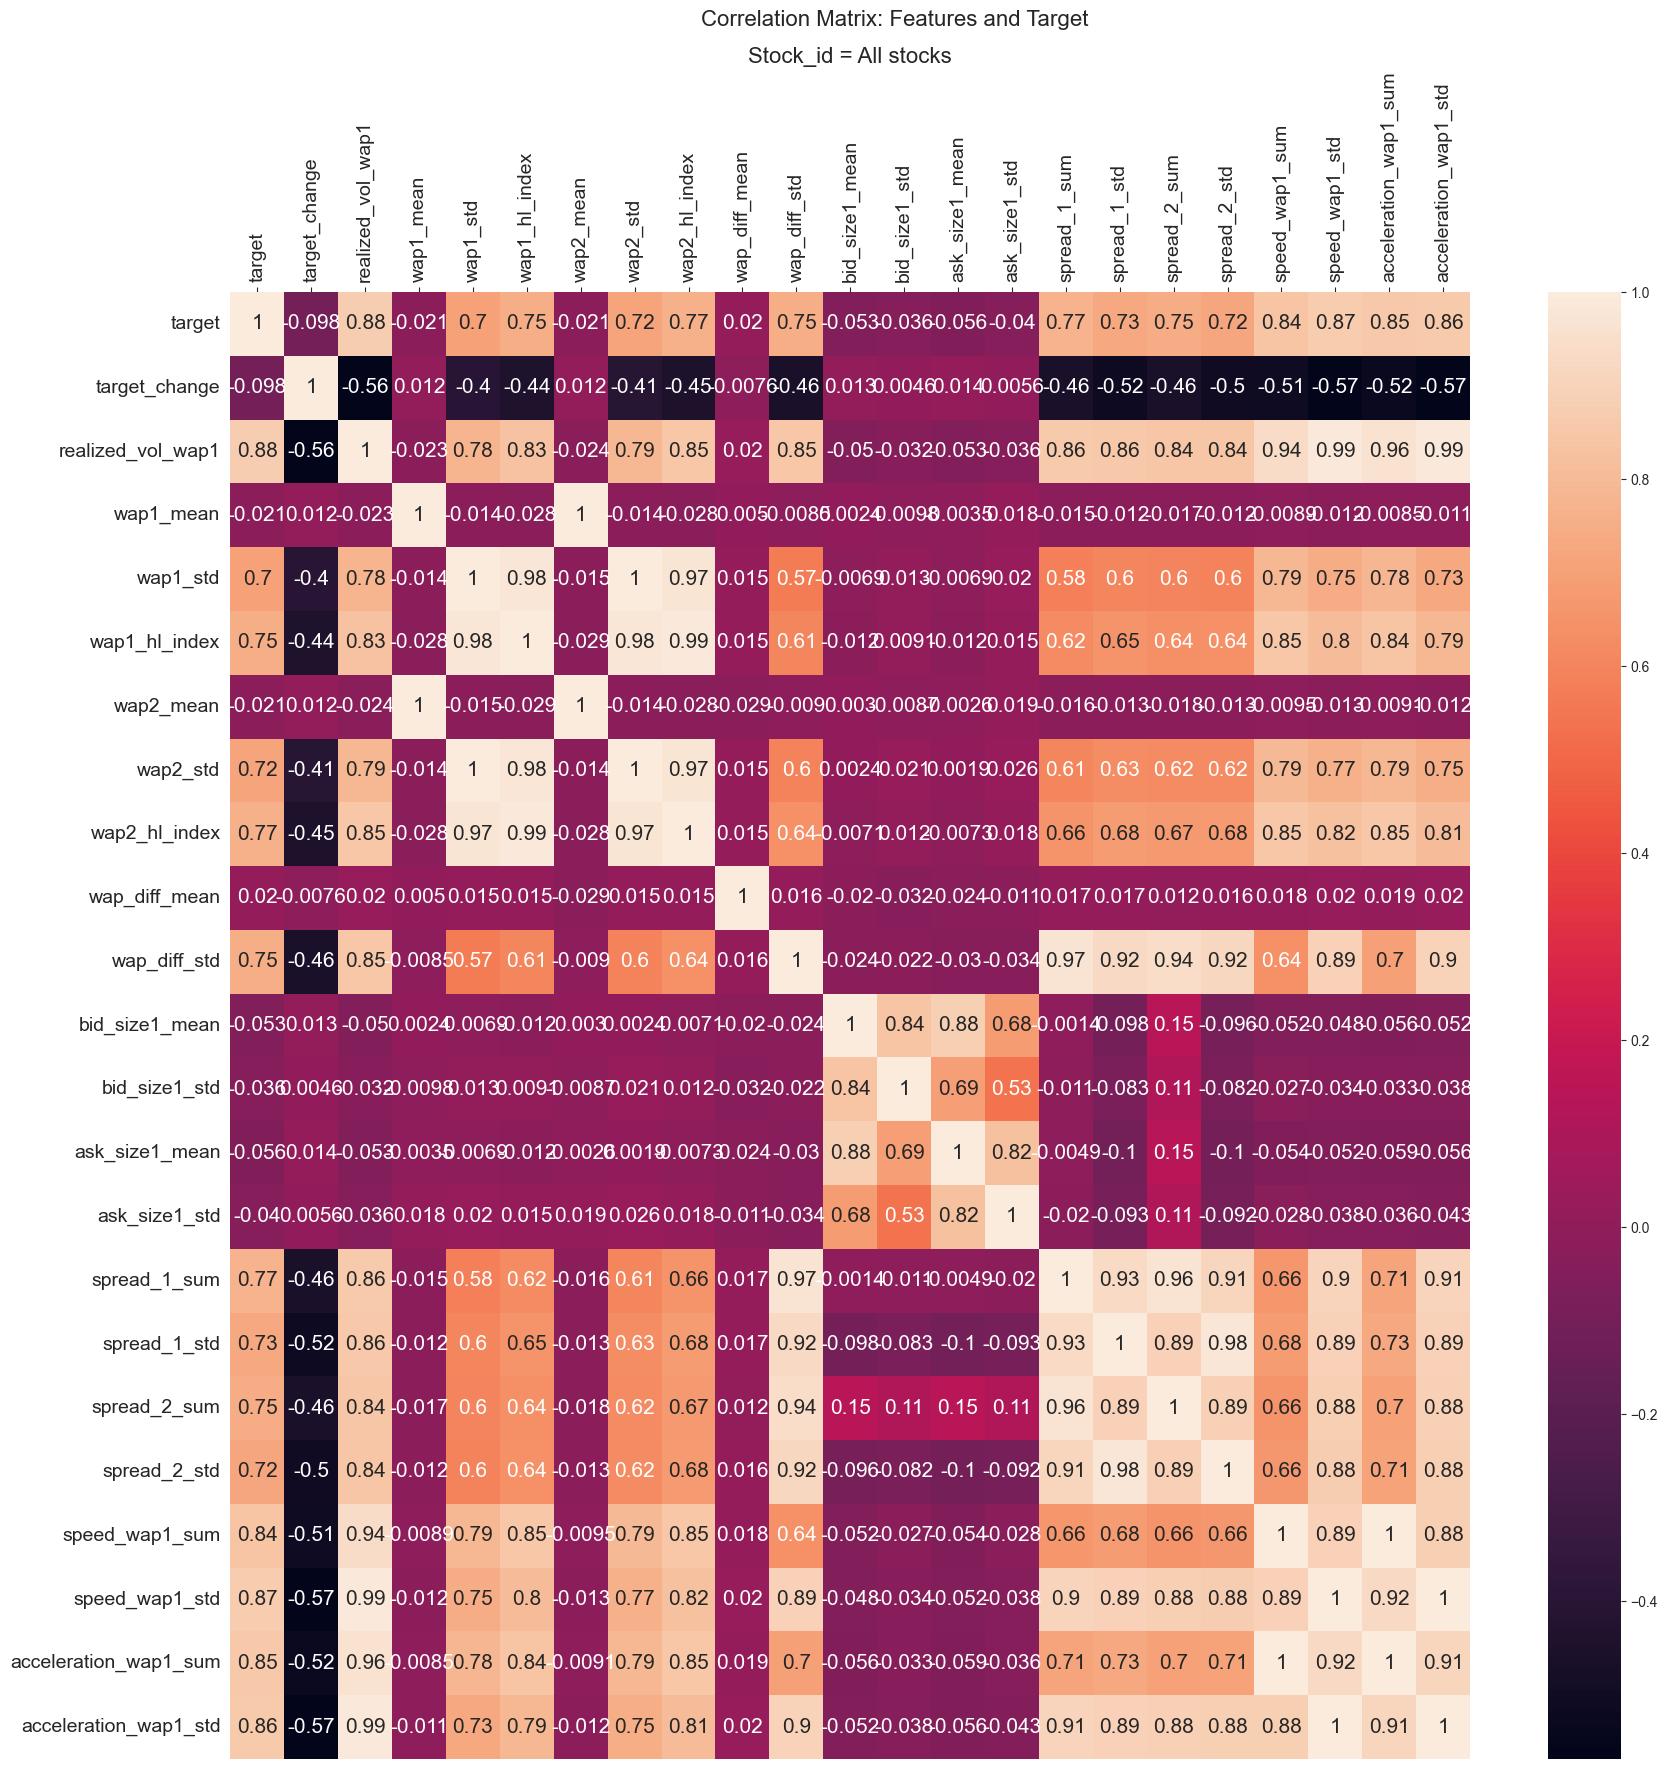

In [105]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(18,18))
ax=sns.heatmap(all_features_lot_1.drop(['time_id', 'stock_id'], axis=1).corr(), annot=True, annot_kws={"size":15})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=90)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Correlation Matrix: Features and Target\n", fontsize=16)
plt.title("Stock_id = All stocks", fontsize=16)
plt.tight_layout()
plt.show()

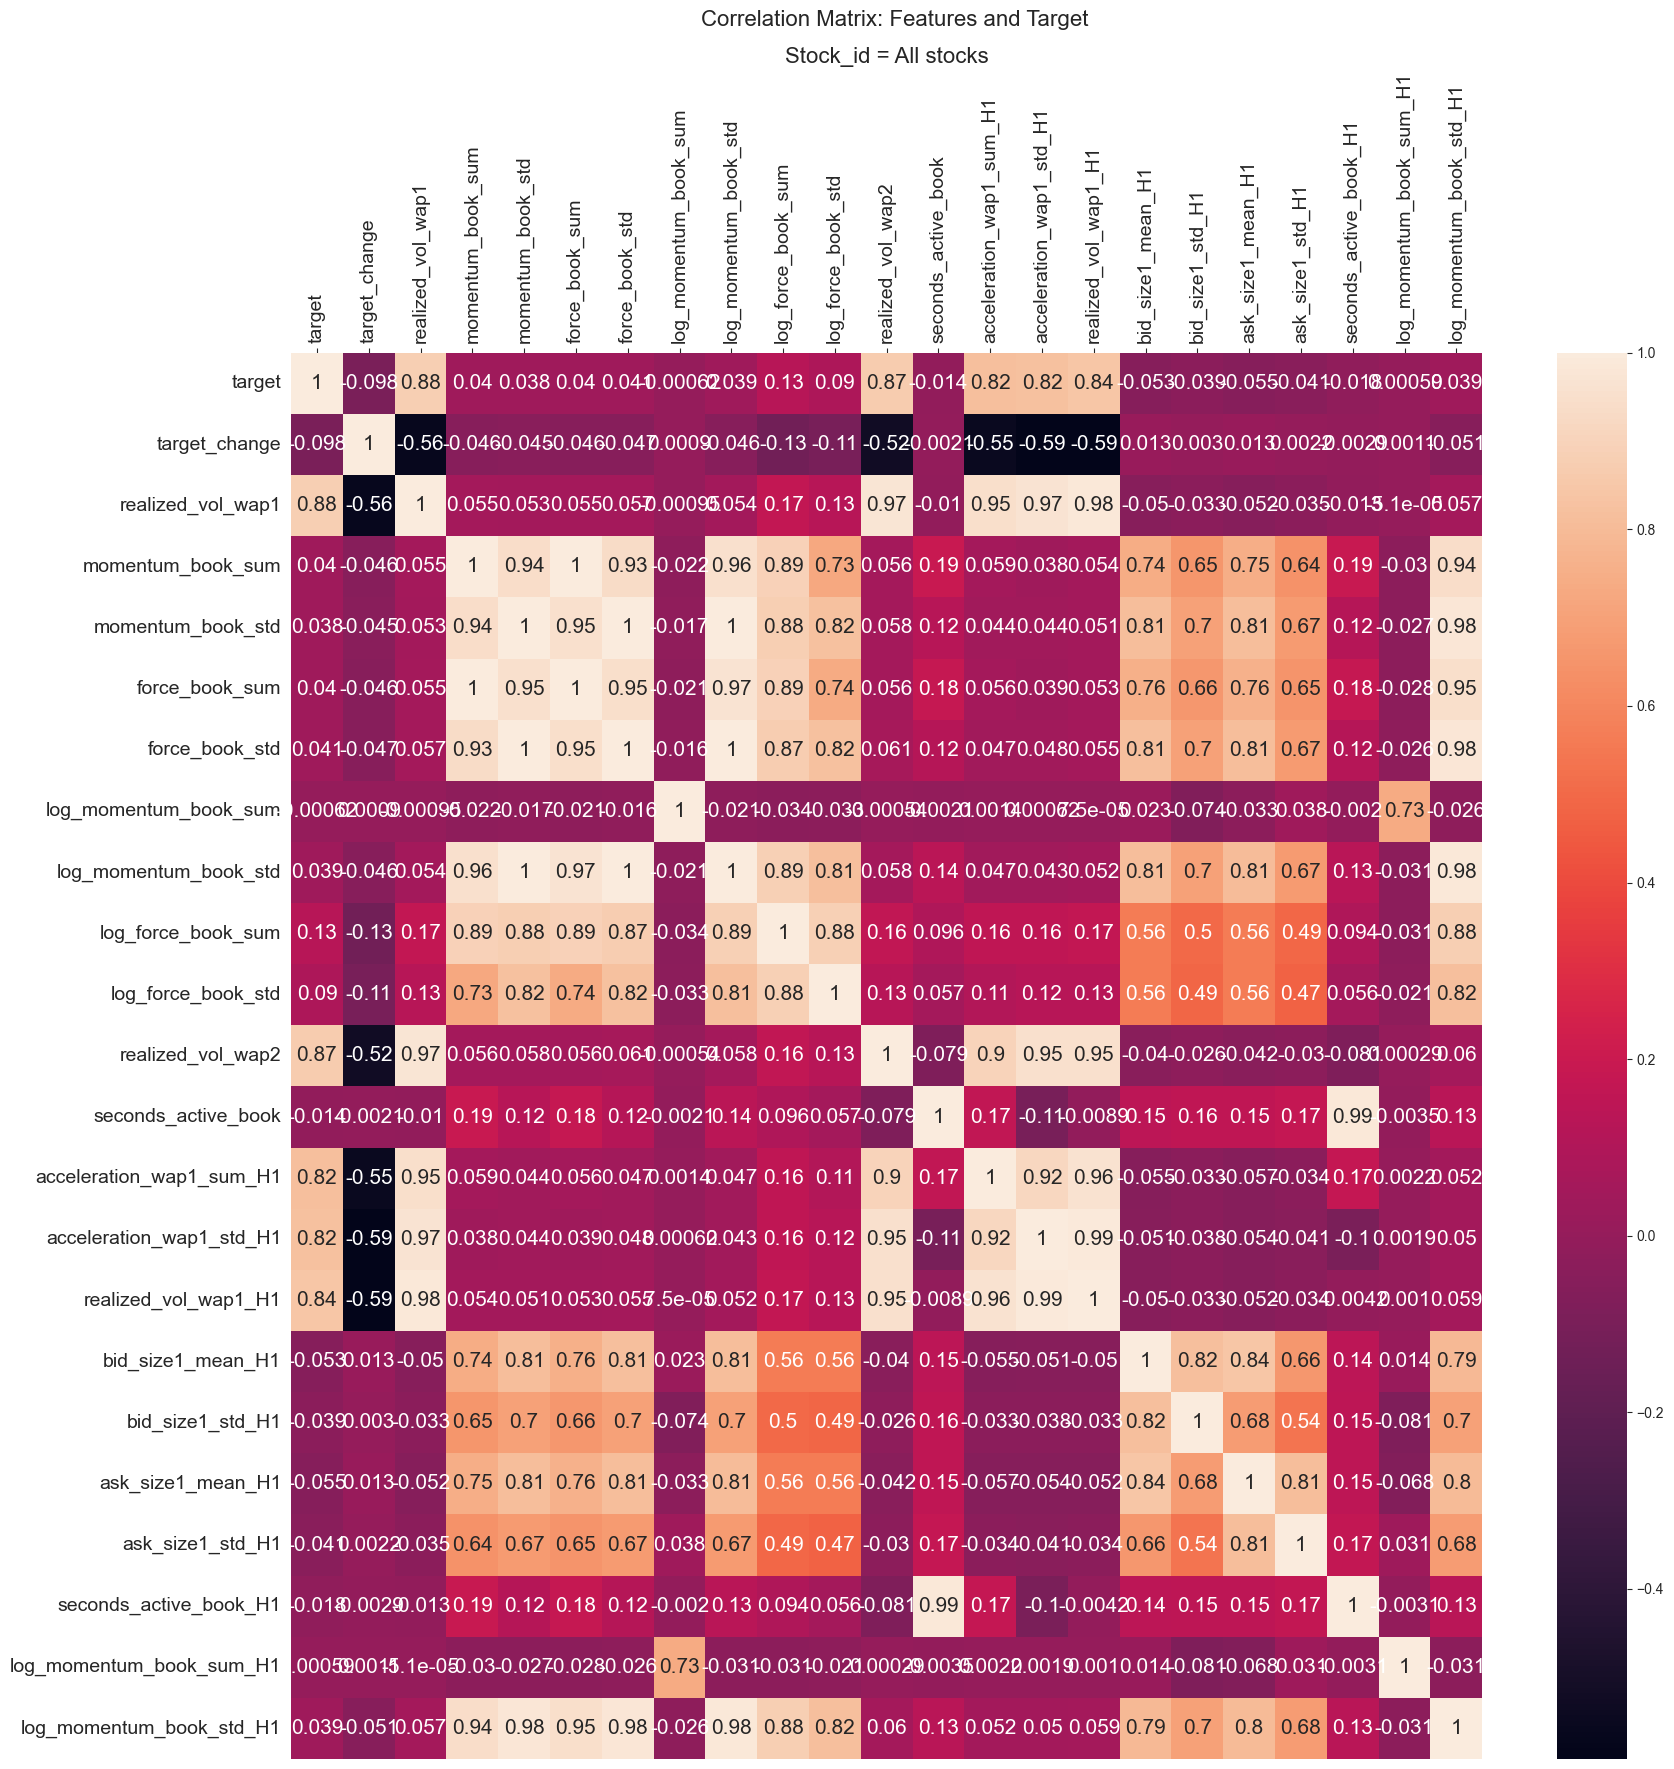

In [106]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(18,18))
ax=sns.heatmap(all_features_lot_2.drop(['time_id', 'stock_id'], axis=1).corr(), annot=True, annot_kws={"size":15})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=90)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Correlation Matrix: Features and Target\n", fontsize=16)
plt.title("Stock_id = All stocks", fontsize=16)
plt.tight_layout()
plt.show()

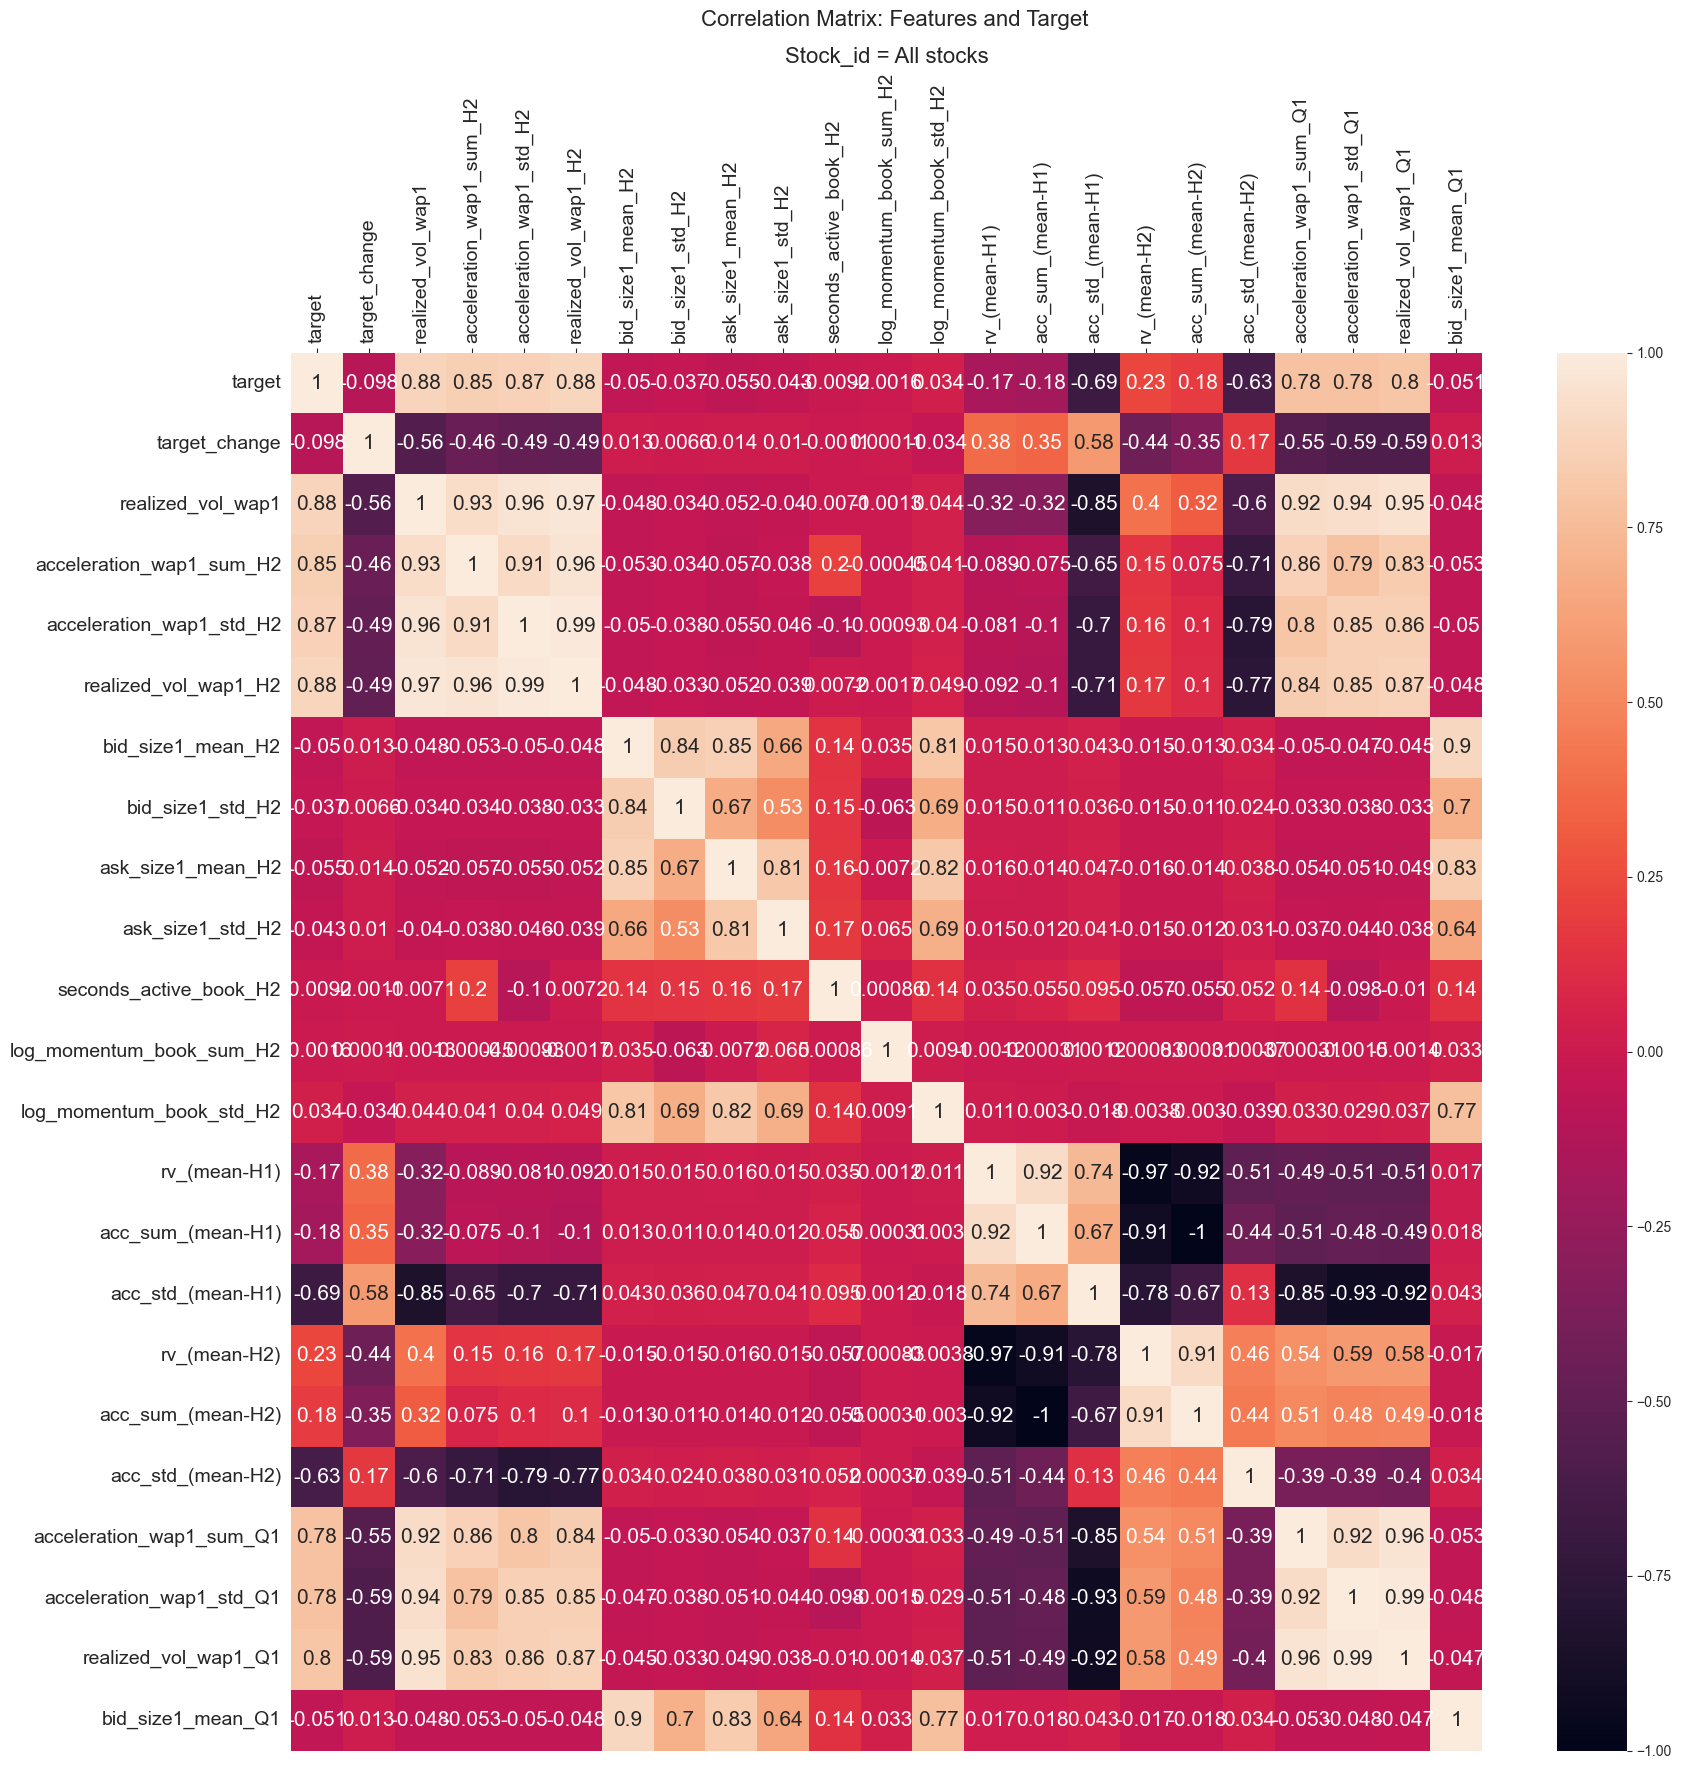

In [107]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(18,18))
ax=sns.heatmap(all_features_lot_3.drop(['time_id', 'stock_id'], axis=1).corr(), annot=True, annot_kws={"size":15})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=90)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Correlation Matrix: Features and Target\n", fontsize=16)
plt.title("Stock_id = All stocks", fontsize=16)
plt.tight_layout()
plt.show()

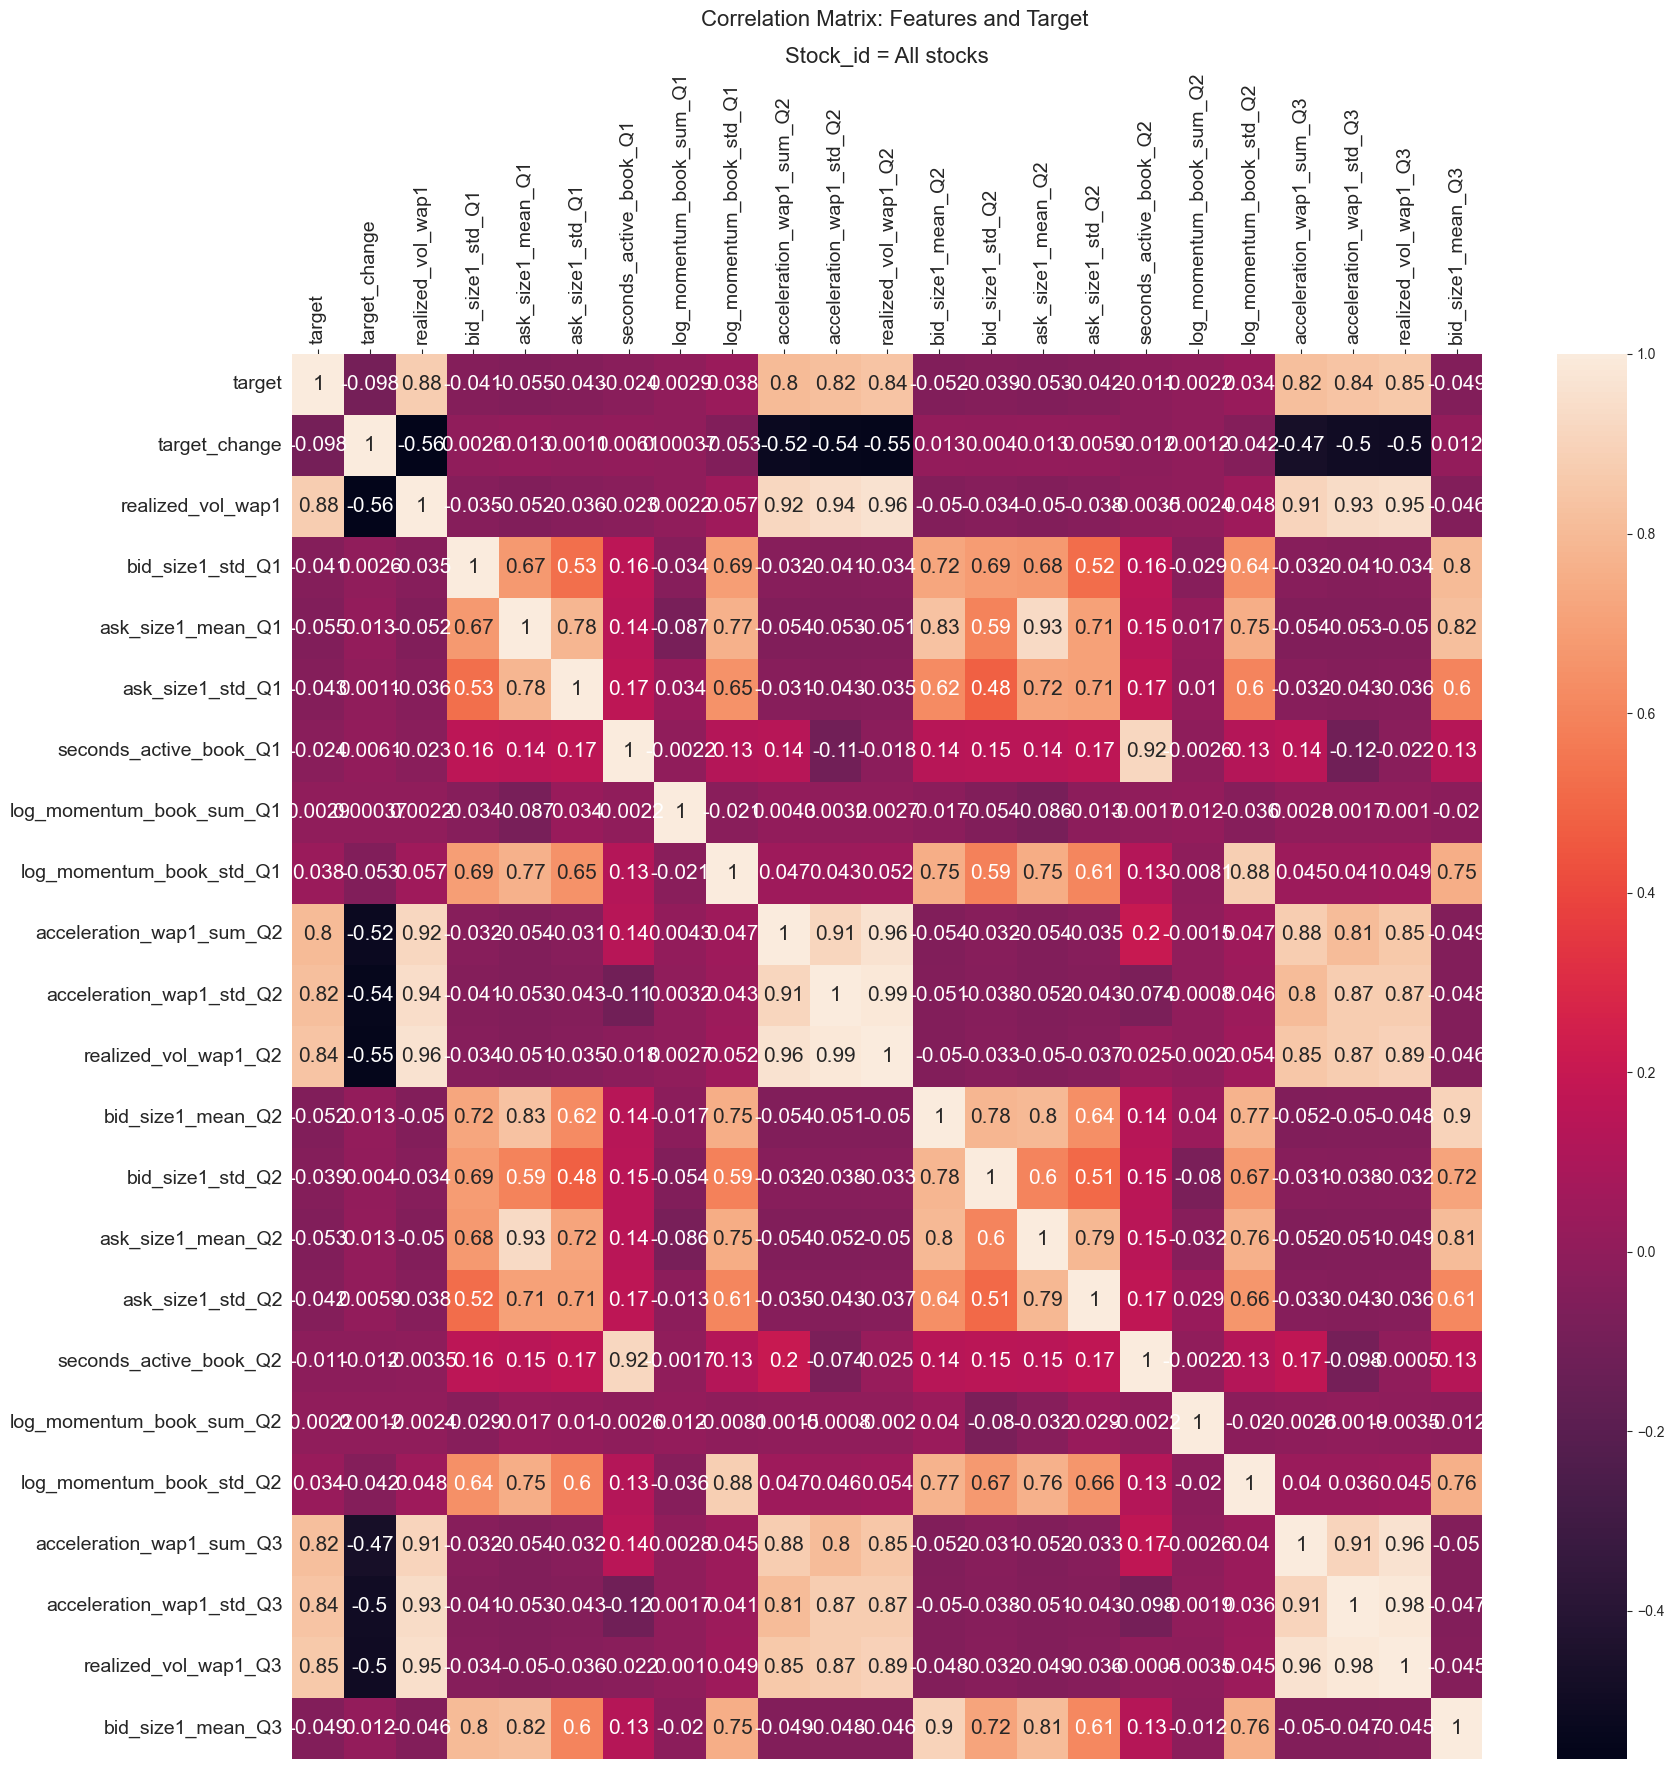

In [108]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(18,18))
ax=sns.heatmap(all_features_lot_4.drop(['time_id', 'stock_id'], axis=1).corr(), annot=True, annot_kws={"size":15})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=90)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Correlation Matrix: Features and Target\n", fontsize=16)
plt.title("Stock_id = All stocks", fontsize=16)
plt.tight_layout()
plt.show()

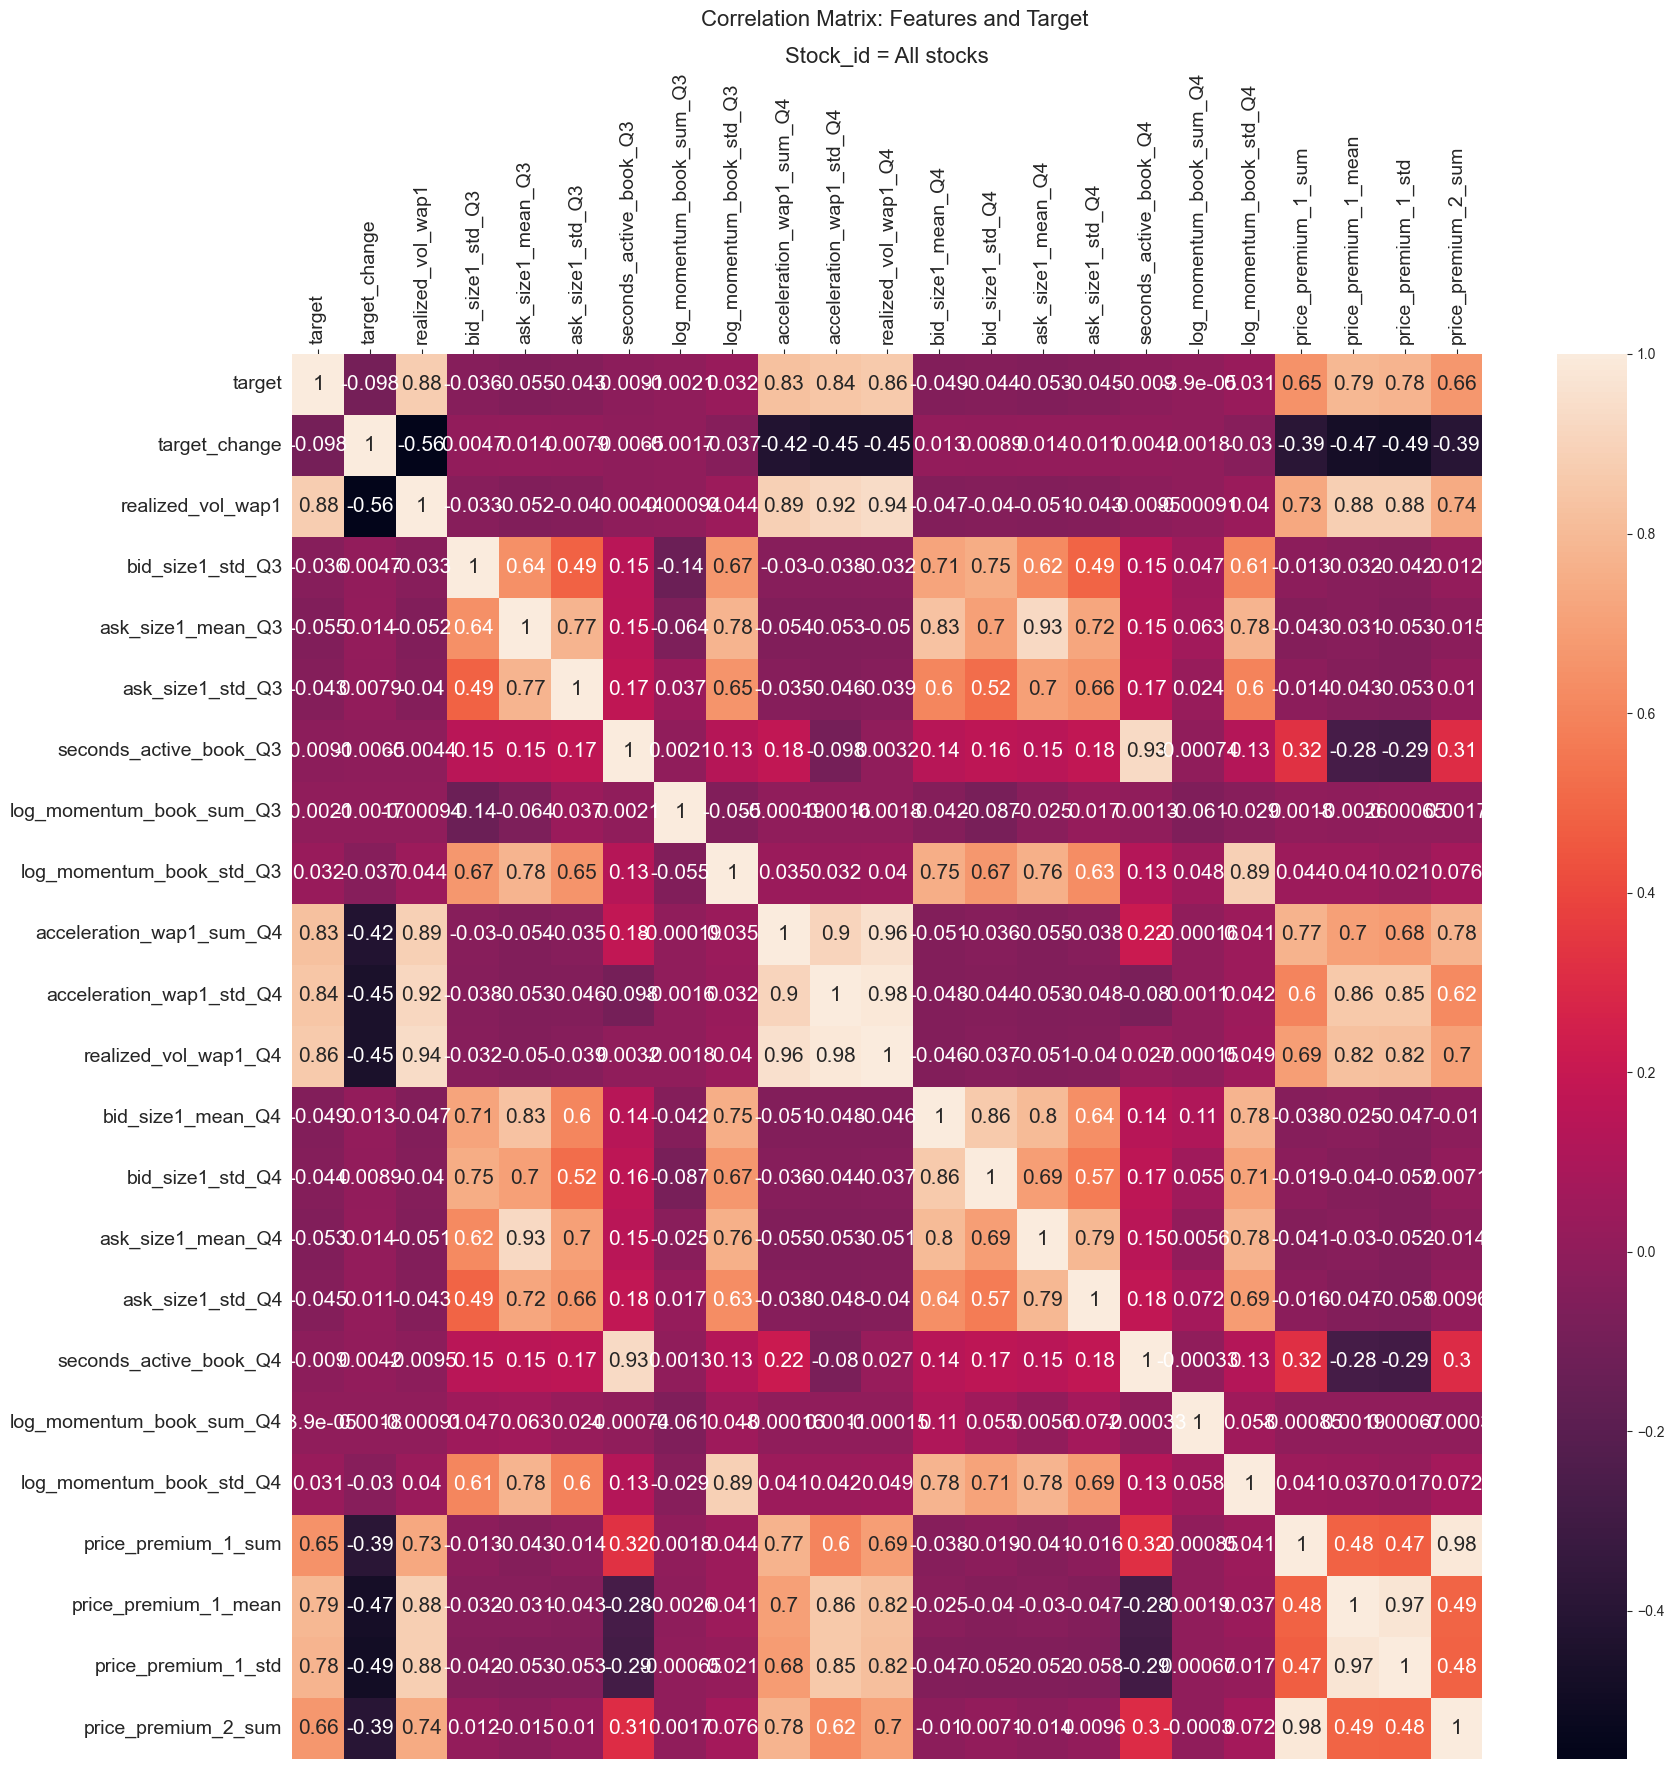

In [110]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(18,18))
ax=sns.heatmap(all_features_lot_5.drop(['time_id', 'stock_id'], axis=1).corr(), annot=True, annot_kws={"size":15})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=90)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Correlation Matrix: Features and Target\n", fontsize=16)
plt.title("Stock_id = All stocks", fontsize=16)
plt.tight_layout()
plt.show()

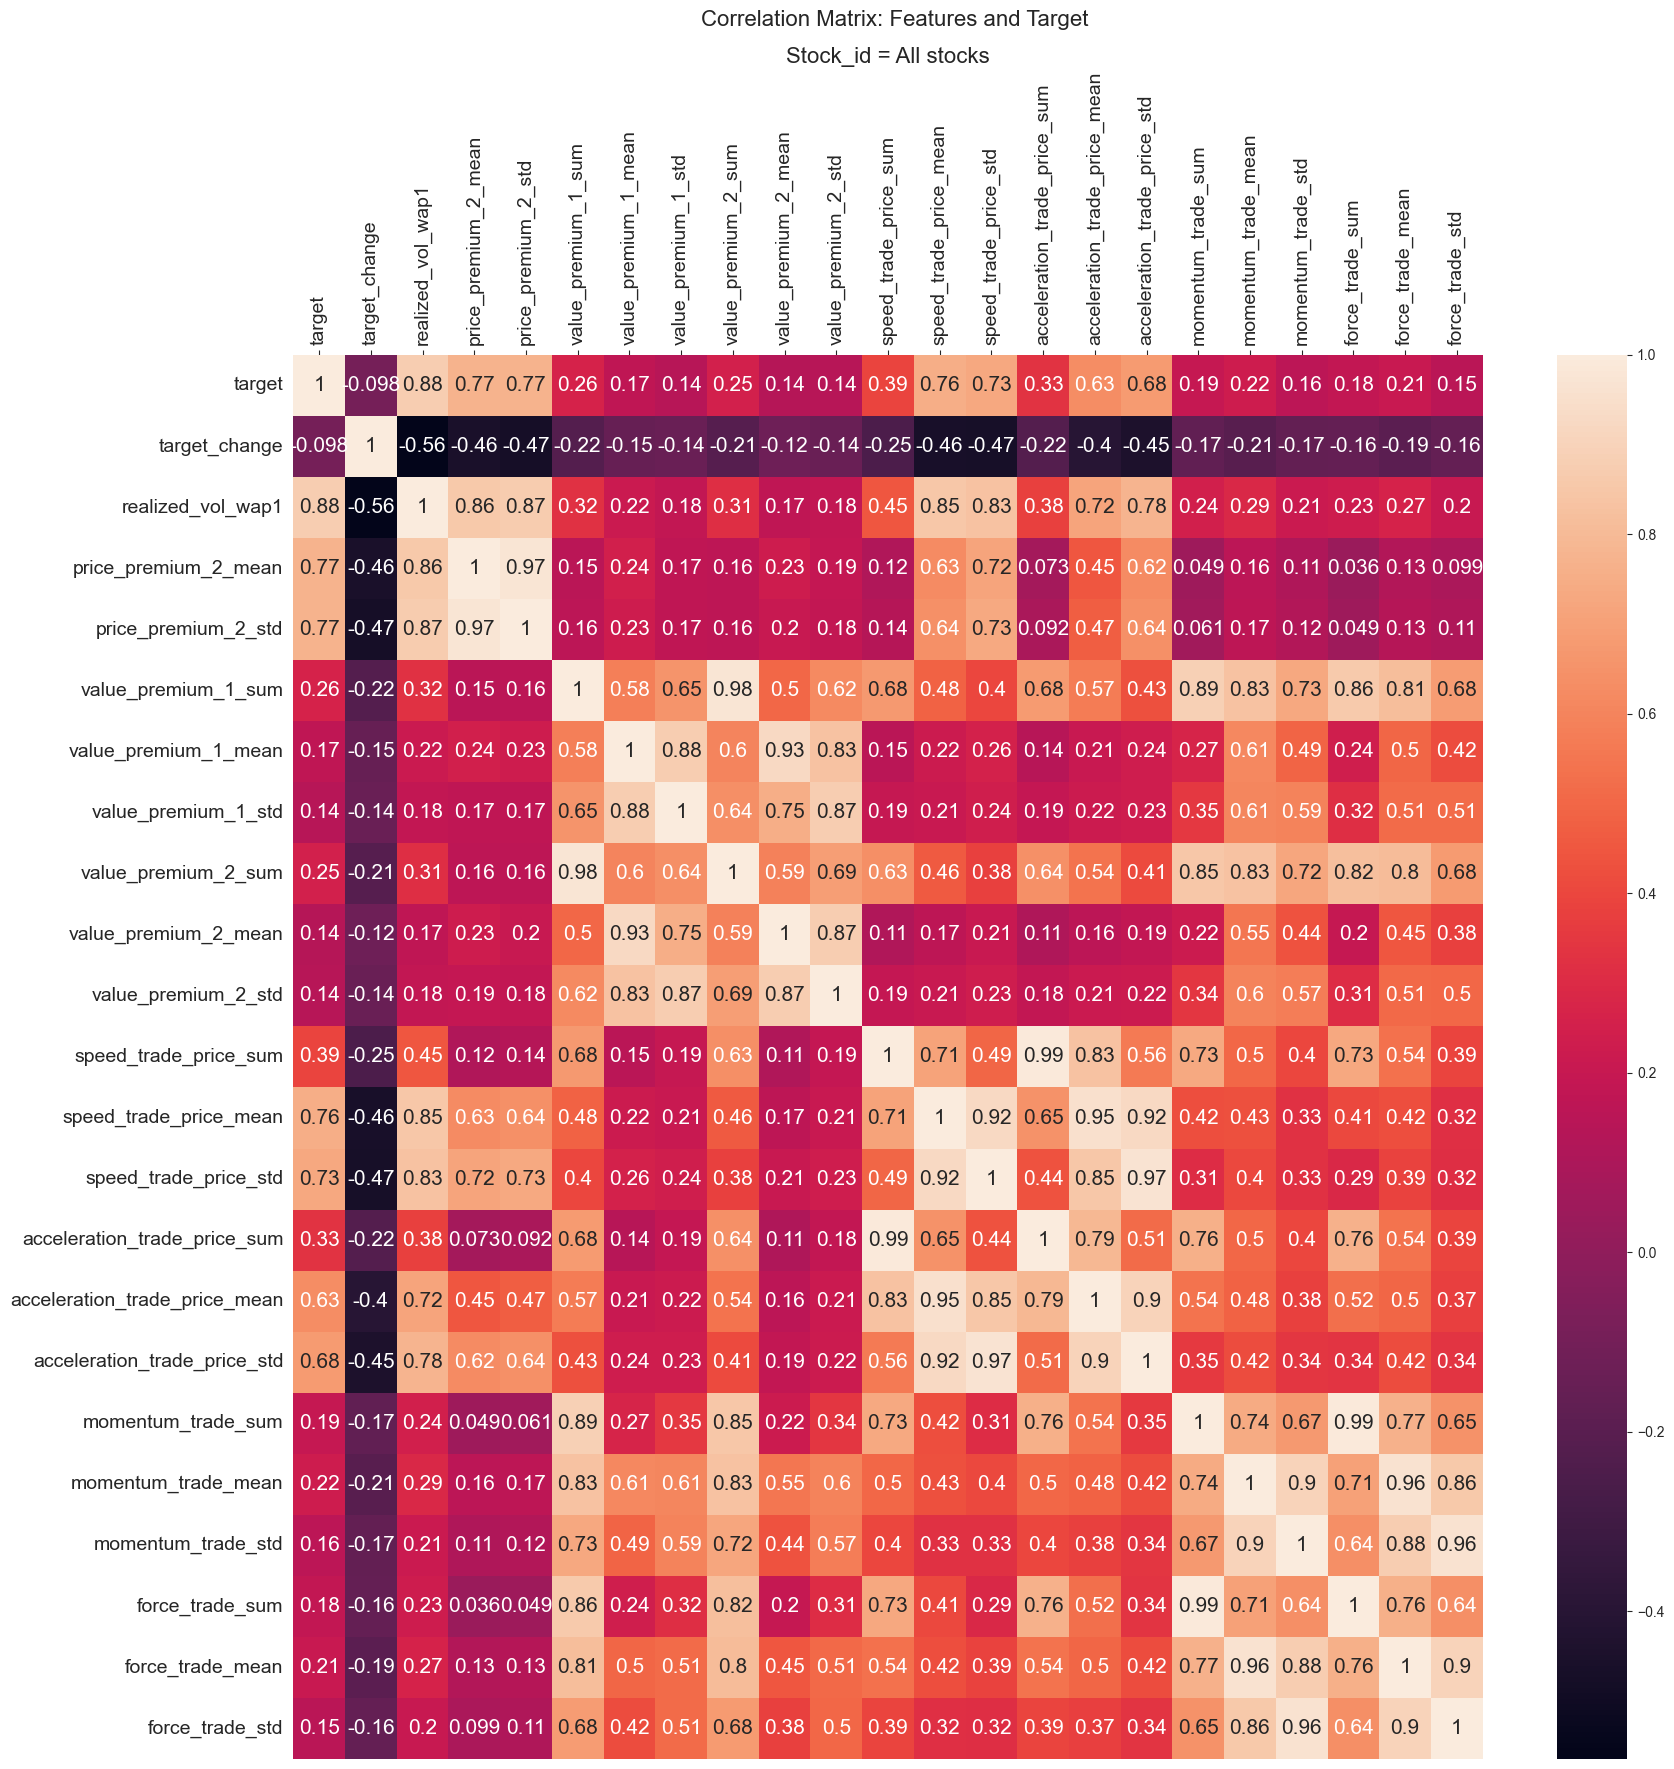

In [111]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(18,18))
ax=sns.heatmap(all_features_lot_6.drop(['time_id', 'stock_id'], axis=1).corr(), annot=True, annot_kws={"size":15})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=90)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Correlation Matrix: Features and Target\n", fontsize=16)
plt.title("Stock_id = All stocks", fontsize=16)
plt.tight_layout()
plt.show()

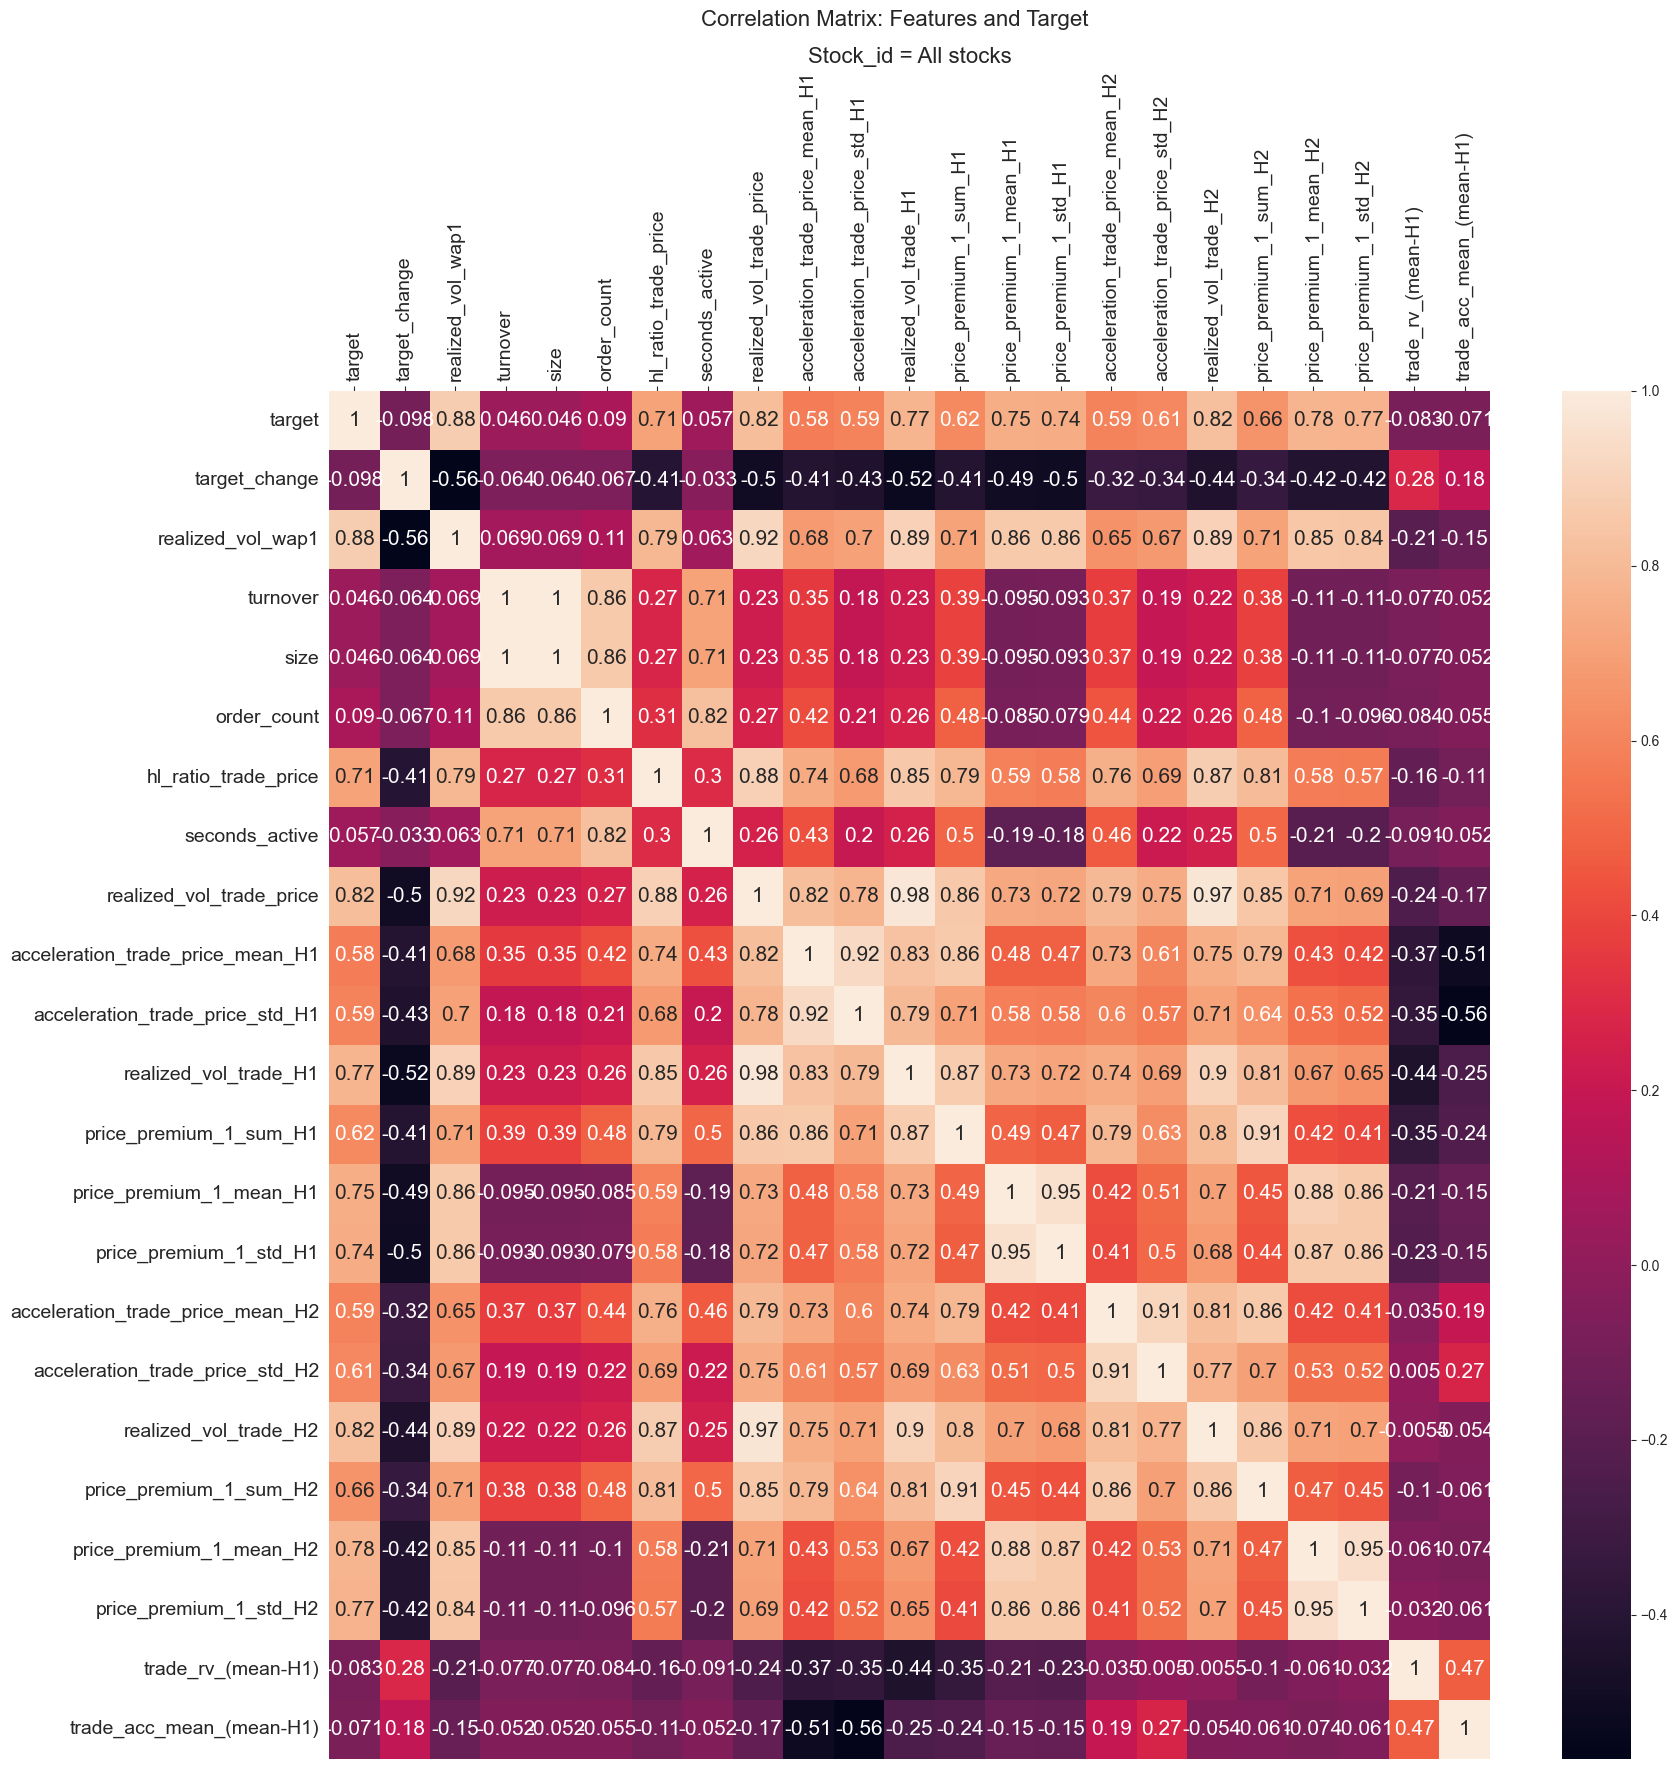

In [112]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(18,18))
ax=sns.heatmap(all_features_lot_7.drop(['time_id', 'stock_id'], axis=1).corr(), annot=True, annot_kws={"size":15})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=90)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Correlation Matrix: Features and Target\n", fontsize=16)
plt.title("Stock_id = All stocks", fontsize=16)
plt.tight_layout()
plt.show()

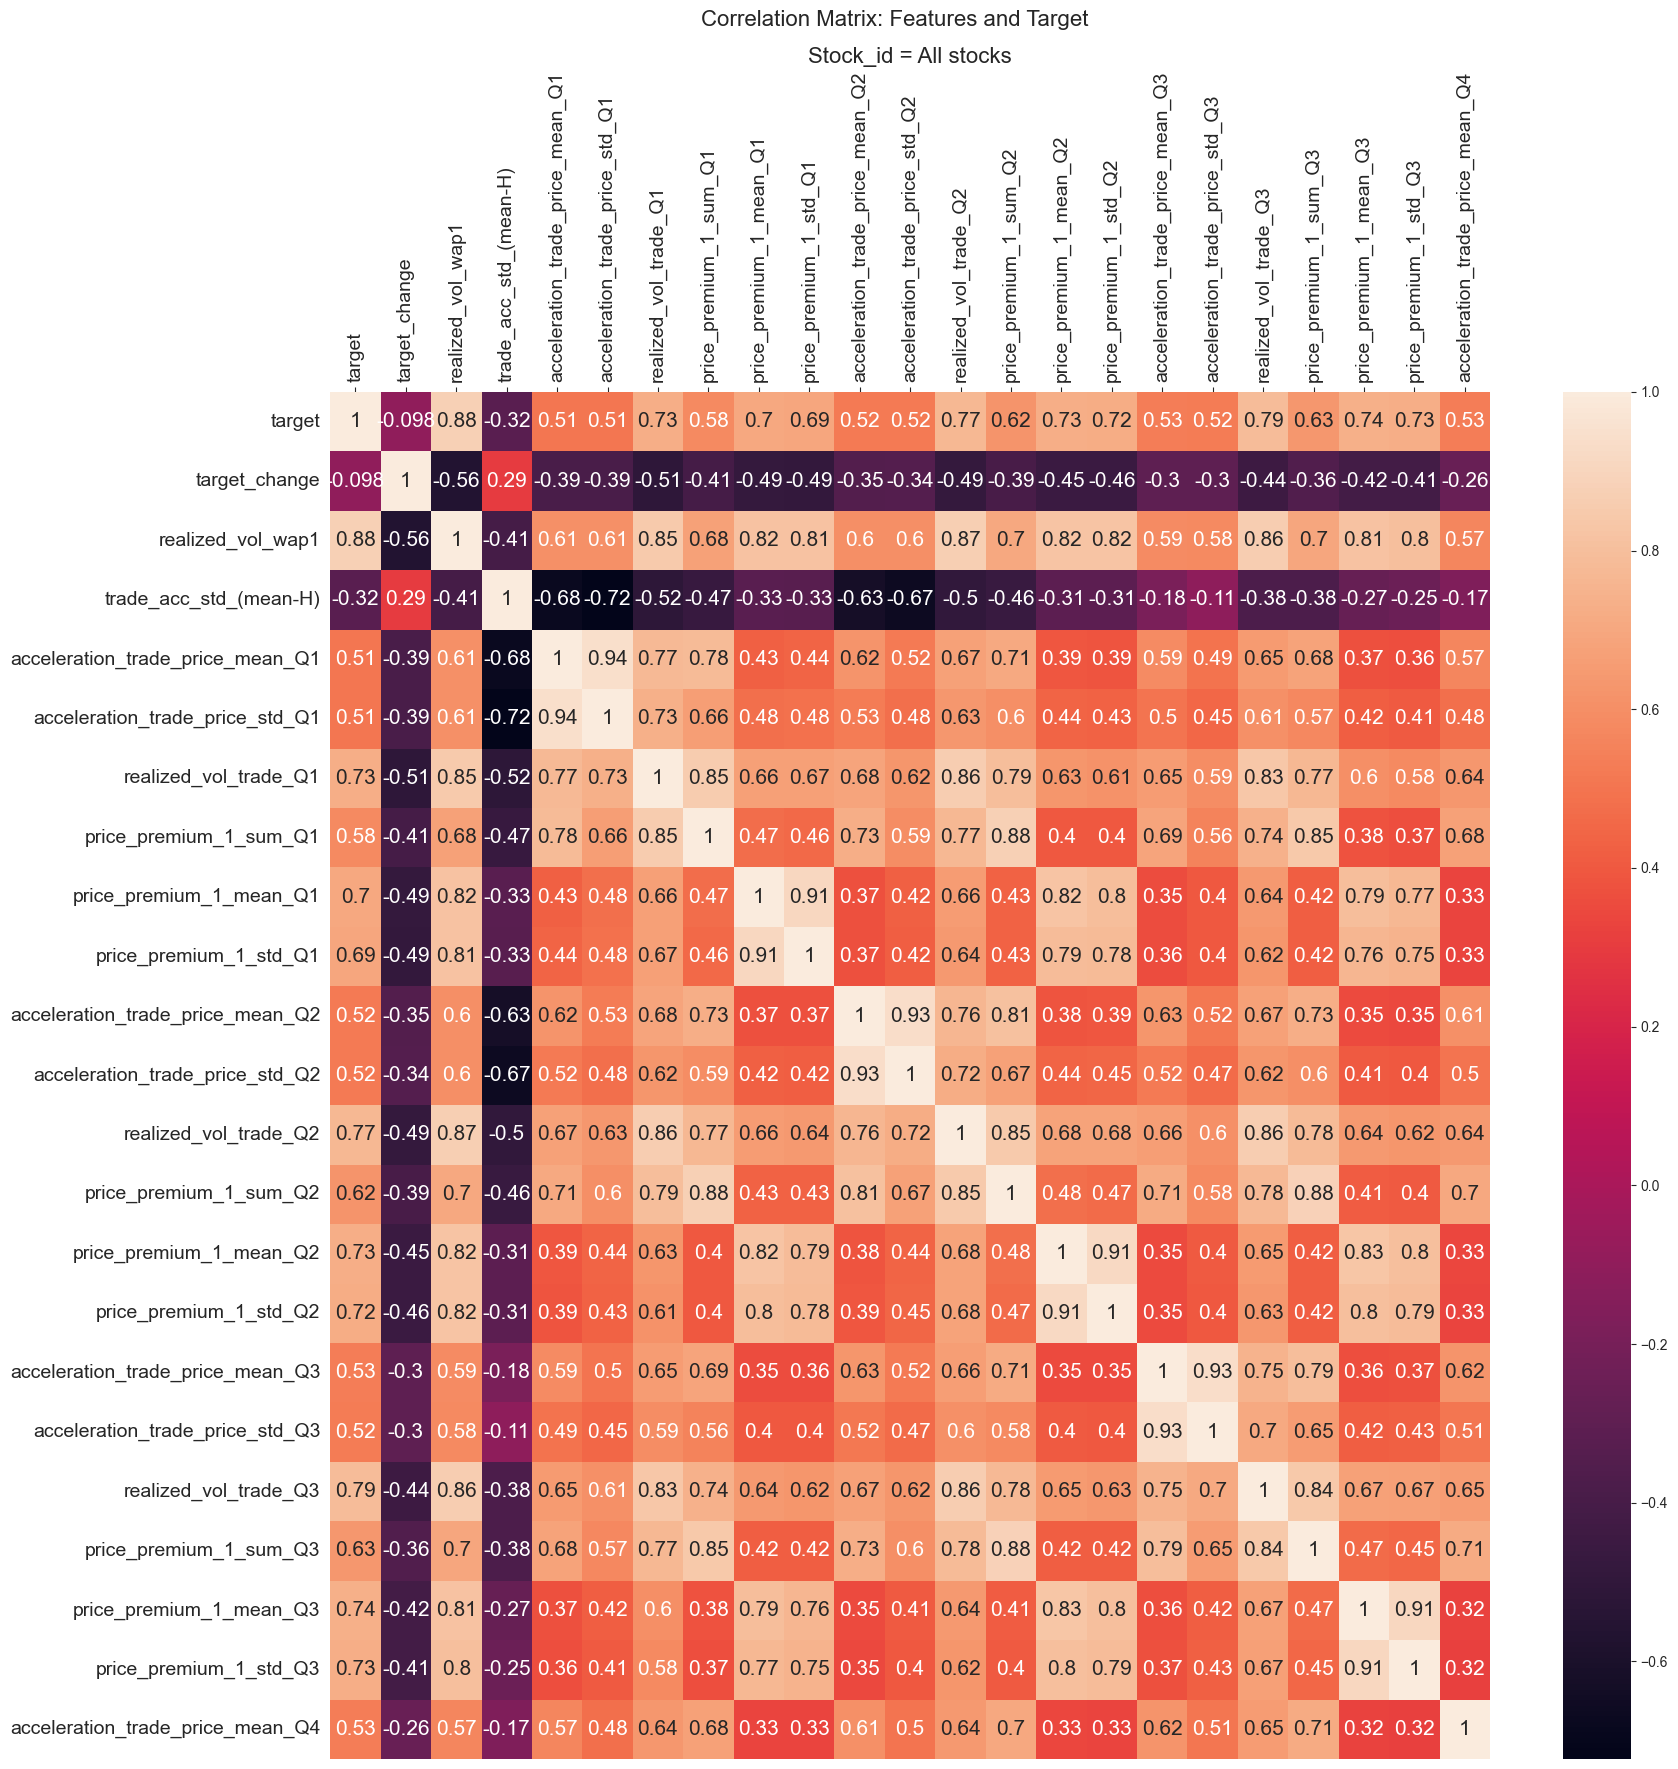

In [113]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(18,18))
ax=sns.heatmap(all_features_lot_8.drop(['time_id', 'stock_id'], axis=1).corr(), annot=True, annot_kws={"size":15})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=90)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Correlation Matrix: Features and Target\n", fontsize=16)
plt.title("Stock_id = All stocks", fontsize=16)
plt.tight_layout()
plt.show()

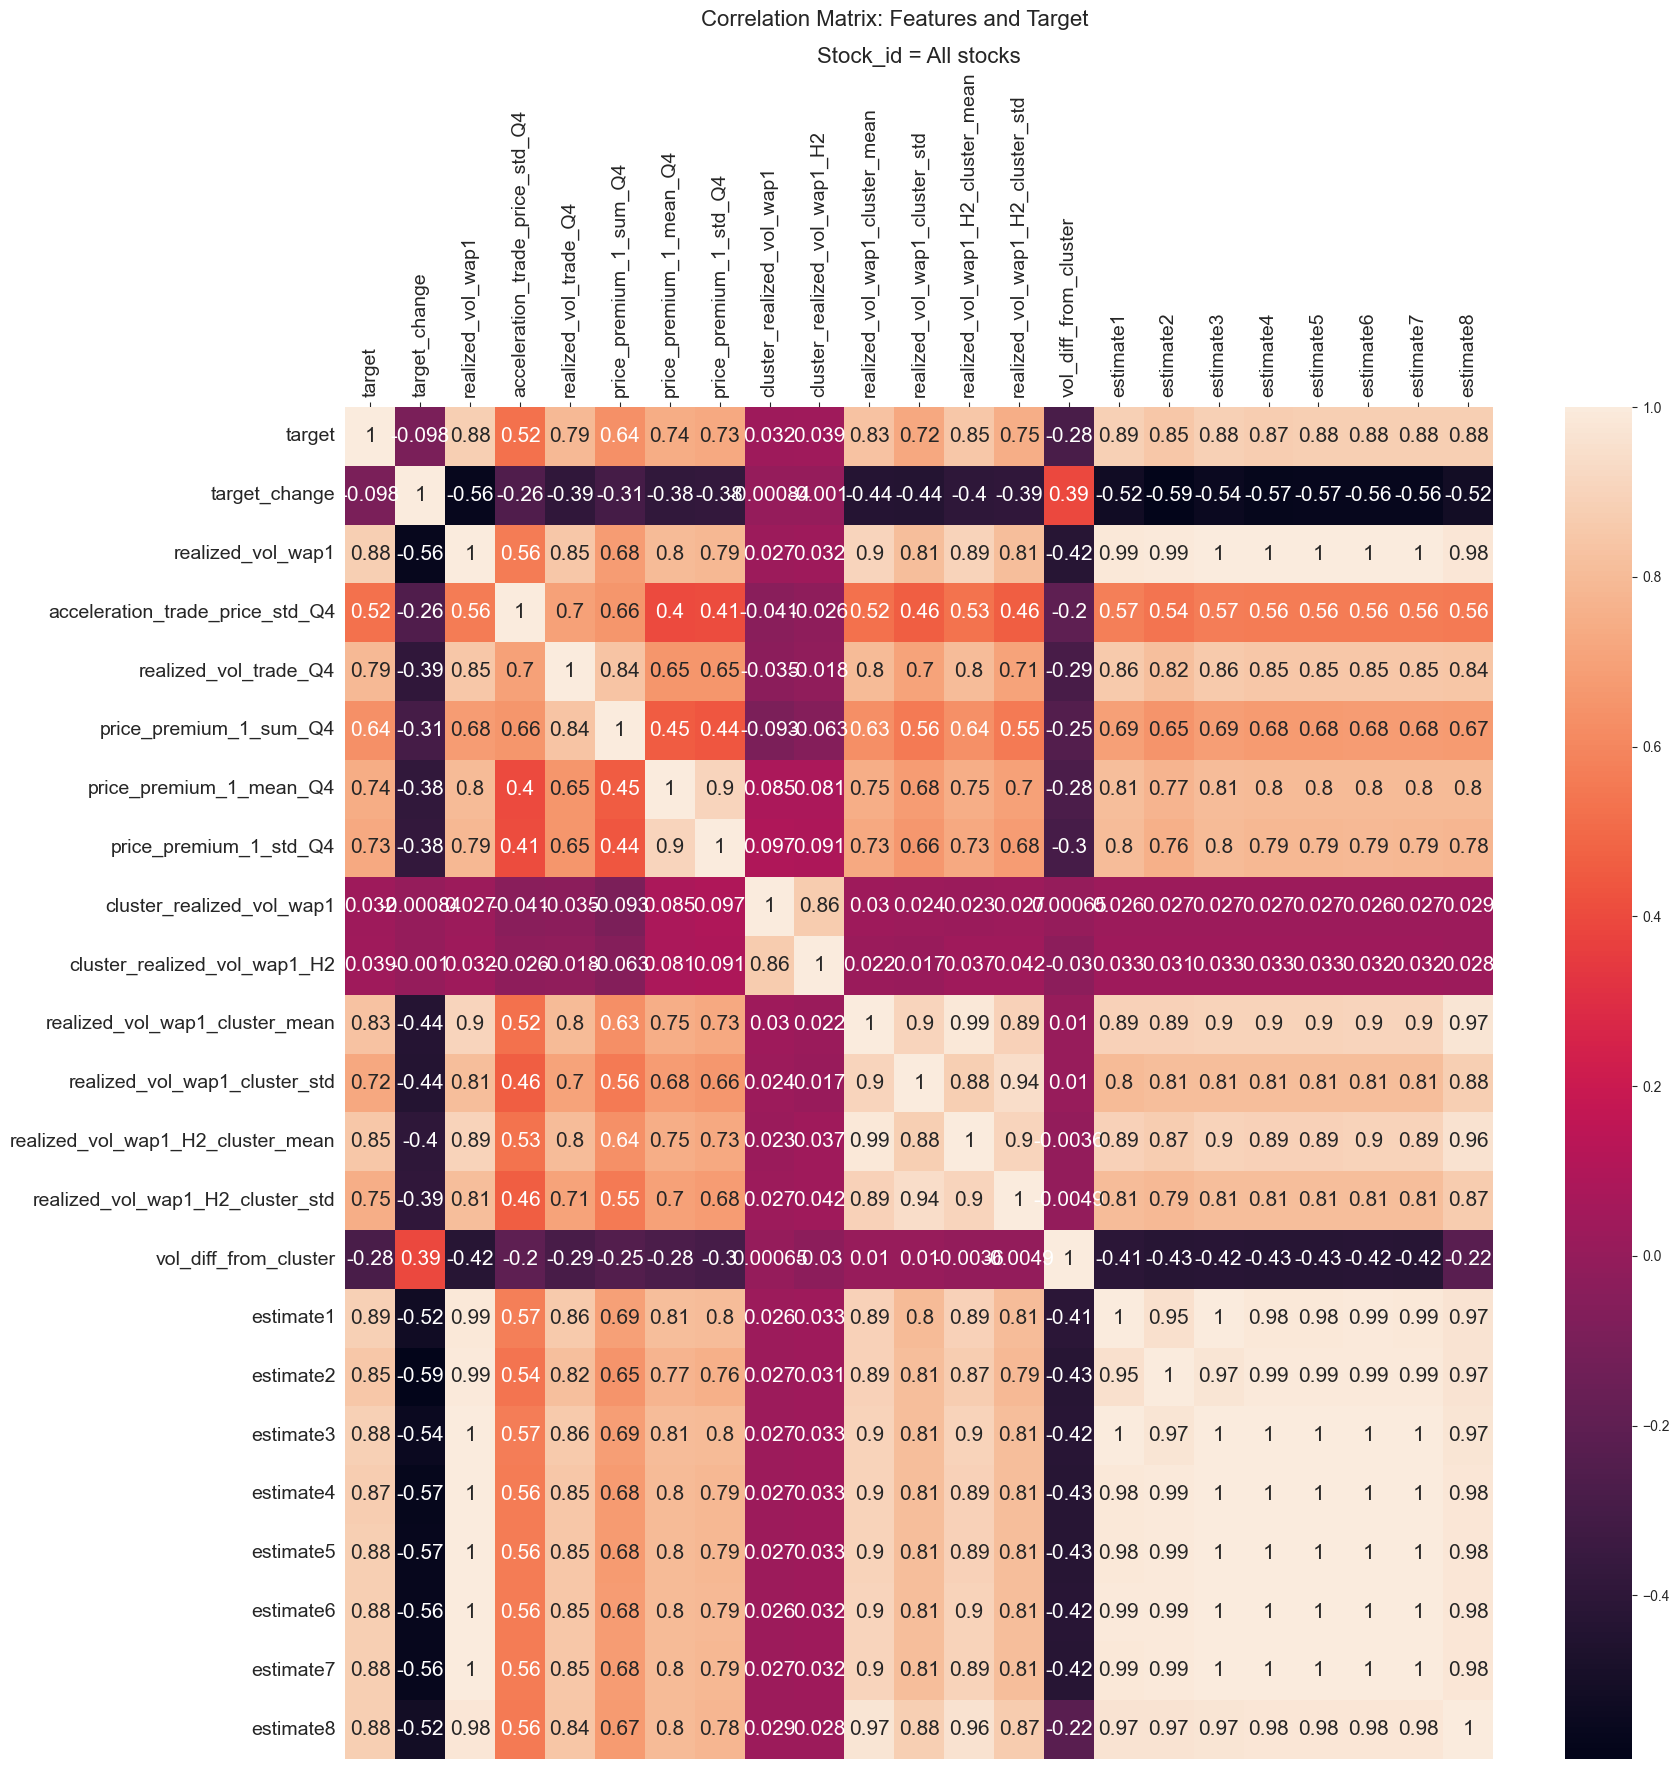

In [114]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(18,18))
ax=sns.heatmap(all_features_lot_9.drop(['time_id', 'stock_id'], axis=1).corr(), annot=True, annot_kws={"size":15})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=90)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Correlation Matrix: Features and Target\n", fontsize=16)
plt.title("Stock_id = All stocks", fontsize=16)
plt.tight_layout()
plt.show()

**Key Observation from Correlation heatmaps**

1. **target**: The top features that have significant correlations (based on the Pearson Correlation Coefficient) with the target are:

    * **realized_vol_wap1_band2** : 0.88
    * **realized_vol_wap1**: 0.87
    * **realized_vol_wap2** : 0.86
    * **speed_wap1_std**: 0.86
    * **acceleration_wap1_std**: 0.86
    * **realized_vol_wap1_band2_cluster_mean**: 0.84

2. **target_change**: target_change is negatively correlated to the features that have high correlation to target.

    * **acceleration_wap1_std_band1**: -0.6
    * **acceleration_wap1_std**: -0.58
    * **realized_vol_wap1**: - 0.57
    
     This tells us that as the realized volatility of current 10-minute time period goes higher, the realized volatility of the next 10-minutes i.e. the 'target' is expected to reduce in most cases.

2. **target_change**: target_change is positively correlated to the following features:

    * **acc_std_(mean-band1)**: 0.58 
    * **rv_(mean-band1)**: 0.36

    The correlation of 0.58 with 'acceleration_std_(mean-band1) suggests that if the acceleration standard deviation in band1(first 5 minutes of the current 10-min period) is lower than 50% of the acceleration standard deviation during the full 10-minute period, then target is expected to be higher than realized volatility of the current 10-minute period.
    

### 2.6 Pre-processing the test dataset

Here we preprocess the test dataset. The only difference is that we provide the pre-processor here, the cluster labels generated during the pre-processing of the training dataset.


In [31]:
cluster_labels = pd.read_csv("../WIP_data/preprocess_new/clusters_all_stocks_.csv")
cluster_labels.head()

stock_id  cluster_realized_vol_wap1  cluster_realized_vol_wap1_H2
0         0                          4                             1
1         1                          4                             4
2         2                          3                             3
3         3                          2                             2
4         4                          4                             4

In [33]:
book_path = '../WIP_data/book/test'
trade_path = '../WIP_data/trade/test'
target_file = '../Raw_data/train.csv'
preprocess_path = '../WIP_data/preprocess_new'
features_for_clustering = ['realized_vol_wap1', 'realized_vol_wap1_H2']
no_of_clusters = 4

start_time = time.time()

pp2 = PreProcess()

all_features_test =  pp2.generate_features(book_path, trade_path, preprocess_path, target_file, features_for_clustering, \
                    n_clusters = no_of_clusters, cluster_labels = cluster_labels, data_type = 'test', create_clusters = False)

end_time = time.time()

print(f'Time taken for feature creation on test set of all 112 stocks = {end_time-start_time}')

save_file(all_features_test, "all_stocks_test_set_.csv", preprocess_path)


Time taken for feature creation on test set of all 112 stocks = 1531.6246111392975
Writing file.  "../WIP_data/preprocess_new\all_stocks_test_set_.csv"


## 3.0 Modeling

In [8]:
all_features = pd.read_csv('../WIP_data/preprocess_new/meta_features_all_stocks_.csv')
all_features.head()

stock_id  time_id  wap1_mean  wap1_std  wap1_hl_index  wap2_mean  wap2_std  \
0         0      5.0   1.003694  0.000697       1.003472   1.003594  0.000824   
1         0     11.0   1.000185  0.000263       1.001135   1.000154  0.000276   
2         0     16.0   0.999382  0.000927       1.003665   0.999513  0.001006   
3         0     31.0   0.998780  0.000790       1.002972   0.998638  0.000646   
4         0     62.0   0.999620  0.000273       1.000928   0.999677  0.000299   

   wap2_hl_index  wap_diff_mean  wap_diff_std  ...  \
0       1.003729       0.000100      0.000487  ...   
1       1.001492       0.000031      0.000249  ...   
2       1.003992      -0.000131      0.000447  ...   
3       1.002692       0.000142      0.000432  ...   
4       1.001148      -0.000057      0.000316  ...   

   realized_vol_wap1_H2_cluster_std  vol_diff_from_cluster  estimate1  \
0                          0.000739               0.001514   0.004271   
1                          0.000667               0.001622   0.001334   
2                          0.000421               0.000424   0.001989   
3                          0.000546               0.000648   0.002530   
4                          0.000411               0.000756   0.002075   

   estimate2  estimate3  estimate4  estimate5  estimate6  estimate7  estimate8  
0   0.004727   0.004385   0.004505   0.004502   0.004411   0.004455   0.005256  
1   0.001075   0.001269   0.001211   0.001208   0.001200   0.001202   0.002016  
2   0.002748   0.002179   0.002399   0.002384   0.002308   0.002338   0.002580  
3   0.002618   0.002552   0.002574   0.002574   0.002521   0.002547   0.002898  
4   0.001714   0.001985   0.001903   0.001899   0.001884   0.001889   0.002273  

[5 rows x 185 columns]

### 3.1 Regression model based on numeric features

To build a numeric models, let's first identify the features that are colinear. To do this, we first scale the features using RobustScaler and then identify the features with correlation coefficient > 0.95. 

In [4]:
#all_features = all_features.drop(columns = ['target_change'])

In [5]:
# Drop rows with any missing values and then drop the categorical vairables. After that use RobustScaler to scale the 
# numeric features
all_features = all_features.dropna(how='any')

X = all_features.drop(columns = ['stock_id','time_id','target', 'row_id', \
                                 'cluster_realized_vol_wap1', 'cluster_realized_vol_wap1_H2'])
scaler = RobustScaler().fit(X)
X = scaler.transform(X)
with open('../WIP_data/preprocess_new/regression_robust_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

X.shape

(327942, 179)

In [9]:
# X is a numpy array with the scaled numeric features. We create a dataframe and then calculate the correlation
# coefficients for each pair of features
cols = [col for col in all_features.columns if col not in ['stock_id','time_id','target', 'row_id', \
                                 'cluster_realized_vol_wap1', 'cluster_realized_vol_wap1_H2'] ]
len(cols)

179

In [11]:
X_df = pd.DataFrame(X, columns = cols)
X_df.head()

wap1_mean  wap1_std  wap1_hl_index  wap2_mean  wap2_std  wap2_hl_index  \
0   1.573978 -0.124336       0.028248   1.529341 -0.006006       0.039538   
1   0.070677 -0.652250      -0.688755   0.057680 -0.666329      -0.620982   
2  -0.273128  0.155830       0.087366  -0.216374  0.212493       0.116934   
3  -0.530935 -0.011392      -0.125103  -0.590805 -0.220843      -0.266597   
4  -0.171061 -0.639609      -0.752099  -0.146221 -0.638234      -0.722449   

   wap_diff_mean  wap_diff_std  bid_size1_mean  bid_size1_std  ...  \
0       1.530976      0.928643       -0.452662      -0.344682  ...   
1       0.465179      0.081850       -0.092459       0.037514  ...   
2      -2.015589      0.786772       -0.389984      -0.411632  ...   
3       2.169002      0.734614       -0.126205      -0.188113  ...   
4      -0.878083      0.321118       -0.237362      -0.220965  ...   

   realized_vol_wap1_H2_cluster_std  vol_diff_from_cluster  estimate1  \
0                          0.159198               1.308511   0.416255   
1                          0.030397               1.409798  -0.592650   
2                         -0.407993               0.291060  -0.367692   
3                         -0.185077               0.500643  -0.181833   
4                         -0.427067               0.601623  -0.338091   

   estimate2  estimate3  estimate4  estimate5  estimate6  estimate7  estimate8  
0   0.499690   0.438080   0.455057   0.457276   0.452146   0.455827   0.727913  
1  -0.678940  -0.619763  -0.642439  -0.643284  -0.639829  -0.641789  -0.405509  
2  -0.138957  -0.311007  -0.246770  -0.250466  -0.263186  -0.258539  -0.207940  
3  -0.181116  -0.184313  -0.188332  -0.186898  -0.190706  -0.187949  -0.096882  
4  -0.472699  -0.376822  -0.411932  -0.412449  -0.407393  -0.410043  -0.315530  

[5 rows x 179 columns]

In [14]:
X_df_corr = X_df.corr()
X_df_corr.head()

wap1_mean  wap1_std  wap1_hl_index  wap2_mean  wap2_std  \
wap1_mean       1.000000 -0.014331      -0.028324   0.999431 -0.013666   
wap1_std       -0.014331  1.000000       0.976394  -0.014843  0.996331   
wap1_hl_index  -0.028324  0.976394       1.000000  -0.028818  0.976183   
wap2_mean       0.999431 -0.014843      -0.028818   1.000000 -0.014175   
wap2_std       -0.013666  0.996331       0.976183  -0.014175  1.000000   

               wap2_hl_index  wap_diff_mean  wap_diff_std  bid_size1_mean  \
wap1_mean          -0.027684       0.005015     -0.008457        0.002352   
wap1_std            0.970398       0.015347      0.565140       -0.006883   
wap1_hl_index       0.993386       0.015003      0.606410       -0.012361   
wap2_mean          -0.028177      -0.028724     -0.008993        0.003013   
wap2_std            0.974628       0.015256      0.595286        0.002442   

               bid_size1_std  ...  realized_vol_wap1_H2_cluster_std  \
wap1_mean          -0.009829  ...                         -0.019903   
wap1_std            0.013360  ...                          0.651988   
wap1_hl_index       0.009072  ...                          0.691797   
wap2_mean          -0.008739  ...                         -0.020409   
wap2_std            0.020515  ...                          0.665855   

               vol_diff_from_cluster  estimate1  estimate2  estimate3  \
wap1_mean                   0.027811  -0.026516  -0.019205  -0.024742   
wap1_std                   -0.280643   0.778883   0.756203   0.780319   
wap1_hl_index              -0.311774   0.831043   0.817823   0.835637   
wap2_mean                   0.027797  -0.027167  -0.019858  -0.025399   
wap2_std                   -0.285660   0.793492   0.771342   0.795221   

               estimate4  estimate5  estimate6  estimate7  estimate8  
wap1_mean      -0.022800  -0.022849  -0.023265  -0.023079  -0.018152  
wap1_std        0.775047   0.775704   0.777610   0.776976   0.770260  
wap1_hl_index   0.833224   0.833757   0.835274   0.834770   0.825345  
wap2_mean      -0.023461  -0.023509  -0.023925  -0.023739  -0.018865  
wap2_std        0.790190   0.790815   0.792619   0.792019   0.785320  

[5 rows x 179 columns]

After checking the heatmaps of the correlation coefficients, 89 highly colinear features were found. These have to be removed from the training dataset. 

In [4]:
features_to_remove = ['wap1_std', 'wap2_hl_index', 'spread_1_sum', 'spread_2_std', 'speed_wap1_std',
                     'acceleration_wap1_std', 'force_book_sum', 'force_book_std', 'log_momentum_book_std',
                     'realized_vol_wap2', 'acceleration_wap1_std_H1', 'bid_size1_mean_H1', 'bid_size1_std_H1', 
                      'ask_size1_mean_H1', 'ask_size1_std_H1', 'seconds_active_book_H1', 'log_momentum_book_std_H1',
                     'acceleration_wap1_std_H2', 'log_momentum_book_std_H2', 'bid_size1_mean_H2', 'bid_size1_std_H2',\
                      'ask_size1_mean_H2', 'ask_size1_std_H2', 'seconds_active_book_H2', 'bid_size1_mean_Q1',
                       'bid_size1_std_Q1', 'ask_size1_mean_Q1', 'ask_size1_std_Q1',
                       'seconds_active_book_Q1', 'bid_size1_mean_Q2',
                       'bid_size1_std_Q2', 'ask_size1_mean_Q2', 'ask_size1_std_Q2',
                       'seconds_active_book_Q2', 'bid_size1_mean_Q3', 'bid_size1_std_Q3', 'ask_size1_mean_Q3',
                       'ask_size1_std_Q3', 'seconds_active_book_Q3', 'bid_size1_mean_Q4', 'bid_size1_std_Q4',
                       'ask_size1_mean_Q4', 'ask_size1_std_Q4', 'seconds_active_book_Q4'] + \
                        ['wap2_mean', 'wap2_std', 'acceleration_wap1_sum', 'acceleration_wap1_sum_H1', 
                          'acceleration_wap1_sum_H2'] + \
                        ['hl_ratio_trade_price', 'estimate1', 'estimate2', 'estimate3', 'estimate4', 'estimate5',
                        'estimate6', 'estimate7', 'estimate8'] + \
                        ['acceleration_wap1_sum_Q1', 'acceleration_wap1_std_Q1', 
                           'acceleration_wap1_sum_Q2', 'acceleration_wap1_std_Q2',
                        'acceleration_wap1_sum_Q3','acceleration_wap1_std_Q3', 
                       'acceleration_wap1_sum_Q4', 'acceleration_wap1_std_Q4'] + \
                        ['price_premium_1_mean', 'price_premium_2_sum', 'price_premium_2_std', 'value_premium_2_sum',
                       'speed_trade_price_sum', 'speed_trade_price_std', 'force_trade_sum',
                       'force_trade_mean', 'turnover', 'realized_vol_trade_H1', 'realized_vol_trade_H2', 'realized_vol_trade_Q1',
                        'realized_vol_trade_Q2', 'realized_vol_trade_Q3','realized_vol_trade_Q4'] + \
                        ['momentum_trade_std', 'price_premium_1_sum_H1', 'price_premium_1_std_H1', 'price_premium_1_sum_H2',
                       'price_premium_1_sum_Q1', 'price_premium_1_sum_Q2', 'price_premium_1_sum_Q3', 'price_premium_1_sum_Q4']

len(features_to_remove)

89

In [5]:
X = all_features.drop(columns = features_to_remove)
X.shape

(343143, 96)

In [6]:
#Let's remove the categorical features and then create a LinearRegression model 
X = X.dropna(how='any')
X = X.drop(columns = ['stock_id','time_id', 'row_id', \
                                 'cluster_realized_vol_wap1', 'cluster_realized_vol_wap1_H2'])
X = sm.add_constant(X)
X.head()

const  wap1_mean  wap1_hl_index  wap_diff_mean  wap_diff_std  \
0    1.0   1.003694       1.003472       0.000100      0.000487   
1    1.0   1.000185       1.001135       0.000031      0.000249   
2    1.0   0.999382       1.003665      -0.000131      0.000447   
3    1.0   0.998780       1.002972       0.000142      0.000432   
4    1.0   0.999620       1.000928      -0.000057      0.000316   

   bid_size1_mean  bid_size1_std  ask_size1_mean  ask_size1_std  spread_1_std  \
0       75.300501      77.393534       73.033389      67.841707      0.000212   
1      140.358932     126.675908       66.831386      89.105251      0.000185   
2       86.621035      68.760782      166.181970     107.659481      0.000159   
3      134.263773      97.582401      140.489149     109.503086      0.000252   
4      114.186978      93.346256       93.474124      95.803584      0.000122   

   ...  acceleration_trade_price_mean_Q4  acceleration_trade_price_std_Q4  \
0  ...                      4.695028e-05                     9.252883e-05   
1  ...                      1.899501e-05                     4.512068e-05   
2  ...                      5.800492e-06                     6.519693e-06   
3  ...                      3.902680e-07                     5.352132e-07   
4  ...                      7.162144e-07                     9.500962e-07   

   price_premium_1_mean_Q4  price_premium_1_std_Q4    target  \
0                 0.000180                0.000144  0.004136   
1                 0.000085                0.000097  0.001445   
2                 0.000135                0.000178  0.002168   
3                 0.000444                0.000137  0.002195   
4                 0.000187                0.000218  0.001747   

   realized_vol_wap1_cluster_mean  realized_vol_wap1_cluster_std  \
0                        0.006013                       0.001580   
1                        0.002827                       0.001360   
2                        0.002792                       0.000657   
3                        0.003222                       0.001012   
4                        0.002651                       0.000646   

   realized_vol_wap1_H2_cluster_mean  realized_vol_wap1_H2_cluster_std  \
0                           0.002852                          0.000739   
1                           0.001361                          0.000667   
2                           0.001576                          0.000421   
3                           0.001629                          0.000546   
4                           0.001217                          0.000411   

   vol_diff_from_cluster  
0               0.001514  
1               0.001622  
2               0.000424  
3               0.000648  
4               0.000756  

[5 rows x 92 columns]

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X.drop(columns='target'), X['target'], test_size=0.2, random_state=123)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((262353, 91), (65589, 91), (262353,), (65589,))

In [9]:
pipe = make_pipeline(StandardScaler(), SelectKBest(f_regression), LinearRegression())

k = [x for x in range(10, len(X_train.columns)+1)]
grid_params = {'selectkbest__k': k}

lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=3, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x00000150EB13F040>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [10, 11, 12, 13, 14, 15, 16, 17, 18,
                                            19, 20, 21, 22, 23, 24, 25, 26, 27,
                                            28, 29, 30, 31, 32, 33, 34, 35, 36,
                                            37, 38, 39, ...]})

In [10]:
lr_grid_cv.best_params_

{'selectkbest__k': 85}

In [11]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

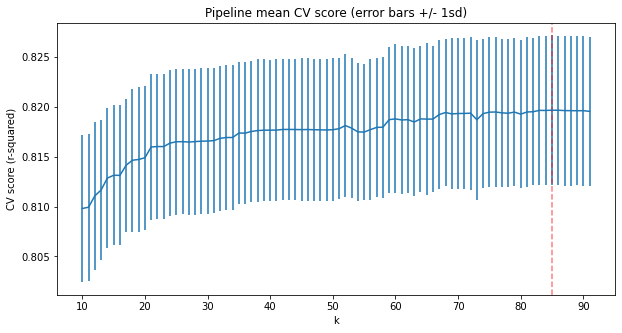

In [13]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')

In [15]:
pipe85 = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression, k=85),
    LinearRegression()
)
pipe85.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=85,
                             score_func=<function f_regression at 0x00000150EB13F040>)),
                ('linearregression', LinearRegression())])

In [16]:
y_tr_pred = pipe85.predict(X_train)
y_val_pred = pipe85.predict(X_val)
tr_loss = rmspe(y_train, y_tr_pred)
val_loss = rmspe(y_val, y_val_pred)
print('RMSPE score of Linear model (After removing simple colinearity)')
print(f'Training dataset: {tr_loss}, Validation dataset: {val_loss}')


RMSPE score of Linear model (After removing simple colinearity)
Training dataset: 0.27291792786056035, Validation dataset: 0.28335153498305043


### 3.2 Removing multi-colinearity to understand feature importance

To remove multicolinearity, we check the vif(variance inflation factor) scores and then remove features until all vif scores for features we care about are below 10.

In [36]:
cols = list(X.columns)
cols.remove('target')
cols.insert(0,'target')
X = X[cols]
X.head()


target  const  wap1_mean  wap1_hl_index  wap_diff_mean  wap_diff_std  \
0  0.004136    1.0   1.003694       1.003472       0.000100      0.000487   
1  0.001445    1.0   1.000185       1.001135       0.000031      0.000249   
2  0.002168    1.0   0.999382       1.003665      -0.000131      0.000447   
3  0.002195    1.0   0.998780       1.002972       0.000142      0.000432   
4  0.001747    1.0   0.999620       1.000928      -0.000057      0.000316   

   bid_size1_mean  bid_size1_std  ask_size1_mean  ask_size1_std  ...  \
0       75.300501      77.393534       73.033389      67.841707  ...   
1      140.358932     126.675908       66.831386      89.105251  ...   
2       86.621035      68.760782      166.181970     107.659481  ...   
3      134.263773      97.582401      140.489149     109.503086  ...   
4      114.186978      93.346256       93.474124      95.803584  ...   

   price_premium_1_std_Q3  acceleration_trade_price_mean_Q4  \
0                0.000341                      4.695028e-05   
1                0.000051                      1.899501e-05   
2                0.000217                      5.800492e-06   
3                0.000084                      3.902680e-07   
4                0.000073                      7.162144e-07   

   acceleration_trade_price_std_Q4  price_premium_1_mean_Q4  \
0                     9.252883e-05                 0.000180   
1                     4.512068e-05                 0.000085   
2                     6.519693e-06                 0.000135   
3                     5.352132e-07                 0.000444   
4                     9.500962e-07                 0.000187   

   price_premium_1_std_Q4  realized_vol_wap1_cluster_mean  \
0                0.000144                        0.006013   
1                0.000097                        0.002827   
2                0.000178                        0.002792   
3                0.000137                        0.003222   
4                0.000218                        0.002651   

   realized_vol_wap1_cluster_std  realized_vol_wap1_H2_cluster_mean  \
0                       0.001580                           0.002852   
1                       0.001360                           0.001361   
2                       0.000657                           0.001576   
3                       0.001012                           0.001629   
4                       0.000646                           0.001217   

   realized_vol_wap1_H2_cluster_std  vol_diff_from_cluster  
0                          0.000739               0.001514  
1                          0.000667               0.001622  
2                          0.000421               0.000424  
3                          0.000546               0.000648  
4                          0.000411               0.000756  

[5 rows x 92 columns]

In [39]:
X = X.rename(columns = {'rv_(mean-H1)' : 'rv_mean_minus_H1', 'acc_sum_(mean-H1)' : 'acc_sum_mean_minus_H1',
                        'acc_std_(mean-H1)' : 'acc_std_mean_minus_H1', 'rv_(mean-H2)' : 'rv_mean_minus_H2', 
                        'acc_sum_(mean-H2)': 'acc_sum_mean_minus_H2','acc_std_(mean-H2)':'acc_std_mean_minus_H2',
                        'trade_rv_(mean-H1)': 'trade_rv_mean_minus_H1', 'trade_acc_mean_(mean-H1)' : 'trade_acc_mean_mean_minus_H1', 
                        'trade_acc_std_(mean-H)' : 'trade_acc_std_mean_minus_H'})


In [41]:
cols = list(X.columns)
cols.remove('target')
features = "+".join(cols)
y, X_df = dmatrices('target ~' + features, X, return_type='dataframe')

In [42]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
vif["features"] = X_df.columns

In [43]:
vif_sorted = vif.sort_values("VIF Factor", ascending=False)
vif_sorted.head(30)

VIF Factor                          features
91         inf             vol_diff_from_cluster
28         inf             acc_sum_mean_minus_H2
21         inf          log_momentum_book_sum_H1
22         inf              realized_vol_wap1_H2
23         inf          log_momentum_book_sum_H2
24         inf                  rv_mean_minus_H1
52         inf     acceleration_trade_price_mean
27         inf                  rv_mean_minus_H2
31         inf          log_momentum_book_sum_Q1
18         inf                 realized_vol_wap1
34         inf          log_momentum_book_sum_Q2
37         inf          log_momentum_book_sum_Q3
40         inf          log_momentum_book_sum_Q4
62         inf   acceleration_trade_price_std_H1
61         inf  acceleration_trade_price_mean_H1
53         inf      acceleration_trade_price_std
20         inf              realized_vol_wap1_H1
25         inf             acc_sum_mean_minus_H1
87         inf    realized_vol_wap1_cluster_mean
70         inf        trade_acc_std_mean_minus_H
69         inf      trade_acc_mean_mean_minus_H1
15         inf             log_momentum_book_sum
30  431.080902              realized_vol_wap1_Q1
36  391.227019              realized_vol_wap1_Q3
39  337.534441              realized_vol_wap1_Q4
14  326.067421                 momentum_book_std
33  308.383673              realized_vol_wap1_Q2
64  222.150973  acceleration_trade_price_mean_H2
26  196.980059             acc_std_mean_minus_H1
66  137.316476           price_premium_1_mean_H2

We find that lot of features have very high vif scores. However, many of these features (e.g 'realized_vol_wap1', 'realized_vol_wap1_cluster_mean') are important features. So we follow an iterative process to gradually remove other features, till we get vif scores of feature we care for below 10.

In [46]:
features_to_drop = ['vol_diff_from_cluster',
 'log_momentum_book_sum_H2',
 'log_momentum_book_sum_H1',
 'acc_sum_mean_minus_H1',
 'acc_sum_mean_minus_H2',
 'log_momentum_book_sum_Q1',
 'log_momentum_book_sum_Q2',
 'log_momentum_book_sum_Q3',
 'log_momentum_book_sum_Q4',
 'acceleration_trade_price_mean_H1',
 'acceleration_trade_price_std_H1',
 'trade_acc_mean_mean_minus_H1',
 'trade_acc_std_mean_minus_H',
 'realized_vol_wap1_H2']
X2 = X.drop(columns = features_to_drop)
X2.shape

(327942, 78)

In [47]:
features_to_drop = [ 'realized_vol_wap1_Q1',
 'realized_vol_wap1_Q3',
 'realized_vol_wap1_Q4',
 'realized_vol_wap1_Q2',
 'acc_std_mean_minus_H1',
 'acceleration_trade_price_mean_H2',
 'price_premium_1_mean_H2',
 'price_premium_1_mean_H1',
 'price_premium_1_std_H2',
 'acceleration_trade_price_mean_Q3',
 'acceleration_trade_price_std_H2',
 'acceleration_trade_price_mean_Q4',
 'price_premium_1_mean_Q3',
 'log_momentum_book_std_Q1',
 'log_momentum_book_std_Q4',
 'log_momentum_book_std_Q3']
X2 = X2.drop(columns = features_to_drop)
X2.shape

(327942, 62)

In [48]:
features_to_drop = [
 'value_premium_2_mean',
 'spread_2_sum',
 'acc_std_mean_minus_H2',
 'acceleration_trade_price_std',
 'acceleration_trade_price_mean_Q2',
 'acceleration_trade_price_mean_Q1',
 'price_premium_2_mean',
 'acceleration_trade_price_std_Q2',
 'value_premium_2_std',
 'acceleration_trade_price_std_Q1',
 'size']
X2 = X2.drop(columns = features_to_drop)
X2.shape

(327942, 51)

In [49]:
features_to_drop = ['price_premium_1_std_Q2', 'price_premium_1_std_Q1','price_premium_1_std_Q3','price_premium_1_std_Q4', 'rv_mean_minus_H1', 'acceleration_trade_price_std_Q3', 'acceleration_trade_price_std_Q4', 
                    'price_premium_1_mean_Q2', 'price_premium_1_mean_Q1', 'price_premium_1_mean_Q4', 
                    'log_momentum_book_std_Q2', 'value_premium_1_sum']
X2 = X2.drop(columns = features_to_drop)
X2.shape

(327942, 39)

In [50]:
features_to_drop = ['speed_trade_price_mean', 'log_force_book_sum', 'realized_vol_wap1_cluster_std', 
                    'realized_vol_wap1_H2_cluster_std', 'price_premium_1_std']
X2 = X2.drop(columns = features_to_drop)
X2.shape


(327942, 34)

In [51]:
cols = list(X2.columns)
cols.remove('target')
features = "+".join(cols)
y, X_df = dmatrices('target ~' + features, X2, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
vif["features"] = X_df.columns
vif_sorted = vif.sort_values("VIF Factor", ascending=False)
vif_sorted.head(34)

VIF Factor                           features
18  682.681240               realized_vol_wap1_H1
16  538.367282                  realized_vol_wap1
11   51.032383                     speed_wap1_sum
32   45.367544     realized_vol_wap1_cluster_mean
33   43.424485  realized_vol_wap1_H2_cluster_mean
13   31.839886                  momentum_book_std
19   27.608102                   rv_mean_minus_H2
30   23.104433           realized_vol_trade_price
5    16.392059                       wap_diff_std
20   15.259150                price_premium_1_sum
23   14.272367       acceleration_trade_price_sum
12   13.178566                  momentum_book_sum
6    10.175123                     bid_size1_mean
21   10.015827               value_premium_1_mean
26    9.862114                momentum_trade_mean
8     9.304582                     ask_size1_mean
10    9.217679                       spread_1_std
24    8.934285      acceleration_trade_price_mean
29    8.141410                     seconds_active
25    6.635495                 momentum_trade_sum
22    6.107371                value_premium_1_std
3     5.357153                      wap1_hl_index
27    5.086353                    force_trade_std
28    5.042165                        order_count
17    4.614987                seconds_active_book
15    4.370327                 log_force_book_std
7     3.994895                      bid_size1_std
9     3.474161                      ask_size1_std
31    1.589659             trade_rv_mean_minus_H1
14    1.126201              log_momentum_book_sum
2     1.033661                          wap1_mean
4     1.006443                      wap_diff_mean
1     0.000000                              const
0     0.000000                          Intercept

In [52]:
features_to_drop = ['speed_wap1_sum', 'realized_vol_wap1_H1', 'realized_vol_wap1_H2_cluster_mean',
                    'acceleration_trade_price_sum', 'wap_diff_std', 'momentum_book_std']
X2 = X2.drop(columns = features_to_drop)
X2.shape

(327942, 28)

In [53]:
features_to_drop = ['momentum_trade_mean']# include it again
X2 = X2.drop(columns = features_to_drop)
X2.shape

(327942, 27)

In [54]:
features_to_drop = ['realized_vol_trade_price']
X2 = X2.drop(columns = features_to_drop)
X2.shape

(327942, 26)

In [55]:
features_to_drop = ['log_momentum_book_sum']#include it again
X2 = X2.drop(columns = features_to_drop)
X2.shape

(327942, 25)

In [56]:
features_to_drop = ['trade_rv_mean_minus_H1']#include it again
X2 = X2.drop(columns = features_to_drop)
X2.shape

(327942, 24)

In [57]:
features_to_drop = ['rv_mean_minus_H2']#include it again
X2 = X2.drop(columns = features_to_drop)
X2.shape

(327942, 23)

In [58]:
features_to_drop = ['price_premium_1_sum']#include it again
X2 = X2.drop(columns = features_to_drop)
X2.shape

(327942, 22)

In [59]:
features_to_drop = ['bid_size1_mean']#include it again
X2 = X2.drop(columns = features_to_drop)
X2.shape

(327942, 21)

In [60]:
features_to_drop = ['spread_1_std'] 
X2 = X2.drop(columns = features_to_drop)
X2.shape

(327942, 20)

In [61]:
cols = list(X2.columns)
cols.remove('target')
features = "+".join(cols)
y, X_df = dmatrices('target ~' + features, X2, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
vif["features"] = X_df.columns
vif_sorted = vif.sort_values("VIF Factor", ascending=False)
vif_sorted.head(20)

VIF Factor                        features
10    7.968612               realized_vol_wap1
12    6.820731            value_premium_1_mean
18    6.401281                  seconds_active
13    5.510960             value_premium_1_std
19    5.491585  realized_vol_wap1_cluster_mean
6     5.473230                  ask_size1_mean
17    4.929183                     order_count
3     4.533733                   wap1_hl_index
14    4.423243   acceleration_trade_price_mean
8     4.100303               momentum_book_sum
15    3.512298              momentum_trade_sum
7     3.269642                   ask_size1_std
11    2.706616             seconds_active_book
9     2.594295              log_force_book_std
16    2.289688                 force_trade_std
5     2.277295                   bid_size1_std
2     1.003564                       wap1_mean
4     1.001994                   wap_diff_mean
1     0.000000                           const
0     0.000000                       Intercept

In [62]:
final_features = list(vif_sorted['features'])
final_features = final_features +['bid_size1_mean', 'price_premium_1_sum', 'rv_mean_minus_H2', 
                                  'trade_rv_mean_minus_H1', 'log_momentum_book_sum', 'momentum_trade_mean']
final_features = ['target'] + final_features
final_features.remove('Intercept')
len(final_features)

26

In [63]:
X2 = X[final_features]
X2.head()

target  realized_vol_wap1  value_premium_1_mean  seconds_active  \
0  0.004136           0.004499              0.023978            39.0   
1  0.001445           0.001204              0.007704            29.0   
2  0.002168           0.002369              0.028882            24.0   
3  0.002195           0.002574              0.037370            14.0   
4  0.001747           0.001895              0.014656            21.0   

   value_premium_1_std  realized_vol_wap1_cluster_mean  ask_size1_mean  \
0             0.044634                        0.006013       73.033389   
1             0.017797                        0.002827       66.831386   
2             0.047415                        0.002792      166.181970   
3             0.051973                        0.003222      140.489149   
4             0.020477                        0.002651       93.474124   

   order_count  wap1_hl_index  acceleration_trade_price_mean  ...  \
0         98.0       1.003472                       0.000022  ...   
1         55.0       1.001135                       0.000008  ...   
2         67.0       1.003665                       0.000031  ...   
3         58.0       1.002972                       0.000025  ...   
4         88.0       1.000928                       0.000008  ...   

   bid_size1_std  wap1_mean  wap_diff_mean  const  bid_size1_mean  \
0      77.393534   1.003694       0.000100    1.0       75.300501   
1     126.675908   1.000185       0.000031    1.0      140.358932   
2      68.760782   0.999382      -0.000131    1.0       86.621035   
3      97.582401   0.998780       0.000142    1.0      134.263773   
4      93.346256   0.999620      -0.000057    1.0      114.186978   

   price_premium_1_sum  rv_mean_minus_H2  trade_rv_mean_minus_H1  \
0             0.010399          0.000228               -0.000102   
1             0.003055         -0.000129               -0.000046   
2             0.004892          0.000380               -0.000211   
3             0.003481          0.000044               -0.000014   
4             0.002486         -0.000180               -0.000128   

   log_momentum_book_sum  momentum_trade_mean  
0               1.135951             0.004188  
1               0.046496             0.001896  
2              -1.046446             0.005299  
3              -1.432027             0.003555  
4              -0.406913             0.000637  

[5 rows x 26 columns]

In [64]:
cols = list(X2.columns)
cols.remove('target')
features = "+".join(cols)
y, X_df = dmatrices('target ~' + features, X2, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
vif["features"] = X_df.columns
vif_sorted = vif.sort_values("VIF Factor", ascending=False)
vif_sorted.head(28)

VIF Factor                        features
25    9.512287             momentum_trade_mean
20    9.472200                  bid_size1_mean
6     8.983602                  ask_size1_mean
1     8.822655               realized_vol_wap1
2     8.491537            value_premium_1_mean
21    8.203072             price_premium_1_sum
3     6.794630                  seconds_active
9     6.640426   acceleration_trade_price_mean
4     5.810010             value_premium_1_std
5     5.505904  realized_vol_wap1_cluster_mean
15    5.010561                 force_trade_std
7     4.974507                     order_count
8     4.726221                   wap1_hl_index
10    4.613834               momentum_book_sum
11    4.534539              momentum_trade_sum
16    3.986017                   bid_size1_std
12    3.466752                   ask_size1_std
13    2.725483             seconds_active_book
14    2.643364              log_force_book_std
22    1.681995                rv_mean_minus_H2
23    1.497645          trade_rv_mean_minus_H1
24    1.125275           log_momentum_book_sum
17    1.018634                       wap1_mean
18    1.006088                   wap_diff_mean
19    0.000000                           const
0     0.000000                       Intercept

In [146]:
preprocess_path = '../WIP_data/preprocess_new'
save_file(X2, "regression_dataset_final_all_stocks.csv", preprocess_path)

Writing file.  "../WIP_data/preprocess_new\regression_dataset_final_all_stocks.csv"


In [65]:
X_train, X_val, y_train, y_val = train_test_split(X2.drop(columns='target'), X2['target'], test_size=0.2, random_state=123)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((262353, 25), (65589, 25), (262353,), (65589,))

In [66]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [67]:
y_tr_pred = pipe.predict(X_train)
y_val_pred = pipe.predict(X_val)
tr_loss = rmspe(y_train, y_tr_pred)
val_loss = rmspe(y_val, y_val_pred)
print('RMSPE score of Linear model (After removing multicolinearity)')
print(f'Training dataset: {tr_loss}, Validation dataset: {val_loss}')


RMSPE score of Linear model (After removing multicolinearity)
Training dataset: 0.30131824805839075, Validation dataset: 0.31120564986228777


We see that the performance of the model after removing all multicolinear variables has dropped as compared to the earlier model. However, this exercise was done with the objective of understanding feature importance. So let's check out the feature coefficients of this model.


In [76]:
Coef_values = pd.DataFrame({'Coef': X2.drop(columns='target').columns, 'weights': pipe.get_params()['linearregression'].coef_})
Coef_values = Coef_values.sort_values('weights', ascending=False)
Coef_values

Coef       weights
0                realized_vol_wap1  2.069792e-03
4   realized_vol_wap1_cluster_mean  5.924311e-04
20             price_premium_1_sum  2.559763e-04
22          trade_rv_mean_minus_H1  1.260712e-04
7                    wap1_hl_index  8.742610e-05
9                momentum_book_sum  8.278138e-05
14                 force_trade_std  3.483076e-05
1             value_premium_1_mean  1.258734e-05
11                   ask_size1_std  9.962202e-06
16                       wap1_mean  8.058074e-06
15                   bid_size1_std  4.972991e-06
17                   wap_diff_mean  7.673287e-07
18                           const  3.997996e-19
23           log_momentum_book_sum -2.415072e-06
19                  bid_size1_mean -2.839625e-06
2                   seconds_active -1.409950e-05
6                      order_count -1.932193e-05
5                   ask_size1_mean -2.384914e-05
12             seconds_active_book -2.836506e-05
10              momentum_trade_sum -3.737814e-05
13              log_force_book_std -4.506134e-05
3              value_premium_1_std -4.617142e-05
24             momentum_trade_mean -9.674820e-05
8    acceleration_trade_price_mean -1.226120e-04
21                rv_mean_minus_H2 -3.354489e-04

The above table shows that the top 5 features to estimate the target are:
* **'realized_vol_wap1'**: Realized volatility of the prior 10-min period.
* **'realized_vol_wap1_cluster_mean'**: The mean volatility of the cluster a particular stock belongs to. 
* **'rv_mean_minus_H2'**: This feature has a significant -ve weight. It tells how much the volatility of the second half (5-min period) various from the 10-min average.
* **'price_premium_1_sum'**: The premiums paid by trade price over and above the 'wap' price.
* **'trade_rv_mean_minus_H1	'**: How much the trade price volatility of the 1st half (5-min period) various from the 10-min average.

Many other engineered features like acceleration, momentum, high-low index are present in the Top 10 important features.


Next, we build a deep learning model with all the 170+ numeric features

### 3.3 Training a Neural Network Model - with numeric features only

In [9]:
all_features = all_features.dropna(how='any')

y = all_features['target'].to_numpy()
X = all_features.drop(columns = ['stock_id','time_id','target', 'row_id', \
                                 'cluster_realized_vol_wap1', 'cluster_realized_vol_wap1_H2'])
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
with open('../WIP_data/preprocess_new/nn_feature_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)
X.shape

(327942, 179)

In [18]:
set_seed_and_configure_tf_session(5376)

model2 = Sequential()
model2.add(Dense(200,activation=LeakyReLU(alpha=0.5), input_shape=(X.shape[1],)))
model2.add(Dense(200,activation=LeakyReLU(alpha=0.3)))
model2.add(Dense(100,activation=LeakyReLU(alpha=0.3)))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss = keras_rmspe)

model2.summary()
early_stopping_monitor = EarlyStopping(patience=18)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=8, min_lr=0.000001)
save_best = ModelCheckpoint('../WIP_data/preprocess_new/best_nn_model_only_numerical_3layer_200x2_100x1_lrelu.hdf5', \
                            save_best_only=True, save_weight_only=True)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 200)               36000     
                                                                 
 dense_12 (Dense)            (None, 200)               40200     
                                                                 
 dense_13 (Dense)            (None, 100)               20100     
                                                                 
 dense_14 (Dense)            (None, 1)                 101       
                                                                 
Total params: 96,401
Trainable params: 96,401
Non-trainable params: 0
_________________________________________________________________


In [19]:
history2 = model2.fit(X, y, validation_split = 0.2, epochs= 500, batch_size = 128, callbacks=[early_stopping_monitor, reduce_lr, save_best])

model2.save_weights("../WIP_data/preprocess_new/nn_model_only_numerical_3layer_200x2_50x1_lrelu_final_weights.hdf5")

Epoch 1/500
2050/2050 [==============================] - 16s 5ms/step - loss: 23.6434 - val_loss: 1.6457 - lr: 0.0010
Epoch 2/500
2050/2050 [==============================] - 9s 4ms/step - loss: 12.3942 - val_loss: 1.4822 - lr: 0.0010
Epoch 3/500
2050/2050 [==============================] - 10s 5ms/step - loss: 6.0483 - val_loss: 1.6921 - lr: 0.0010
Epoch 4/500
2050/2050 [==============================] - 9s 4ms/step - loss: 3.9249 - val_loss: 1.5022 - lr: 0.0010
Epoch 5/500
2050/2050 [==============================] - 8s 4ms/step - loss: 4.0186 - val_loss: 0.3322 - lr: 0.0010
Epoch 6/500
2050/2050 [==============================] - 8s 4ms/step - loss: 1.0548 - val_loss: 0.9737 - lr: 0.0010
Epoch 7/500
2050/2050 [==============================] - 8s 4ms/step - loss: 1.4099 - val_loss: 0.2849 - lr: 0.0010
Epoch 8/500
2050/2050 [==============================] - 9s 4ms/step - loss: 0.9864 - val_loss: 0.3853 - lr: 0.0010
Epoch 9/500
2050/2050 [==============================] - 8s 4ms/step

2050/2050 [==============================] - 9s 4ms/step - loss: 0.2218 - val_loss: 0.2139 - lr: 6.2500e-05
Epoch 71/500
2050/2050 [==============================] - 9s 4ms/step - loss: 0.2220 - val_loss: 0.2142 - lr: 6.2500e-05
Epoch 72/500
2050/2050 [==============================] - 9s 4ms/step - loss: 0.2197 - val_loss: 0.2138 - lr: 1.5625e-05
Epoch 73/500
2050/2050 [==============================] - 9s 4ms/step - loss: 0.2191 - val_loss: 0.2137 - lr: 1.5625e-05
Epoch 74/500
2050/2050 [==============================] - 9s 4ms/step - loss: 0.2189 - val_loss: 0.2134 - lr: 1.5625e-05
Epoch 75/500
2050/2050 [==============================] - 9s 4ms/step - loss: 0.2182 - val_loss: 0.2141 - lr: 1.5625e-05
Epoch 76/500
2050/2050 [==============================] - 9s 4ms/step - loss: 0.2184 - val_loss: 0.2130 - lr: 1.5625e-05
Epoch 77/500
2050/2050 [==============================] - 8s 4ms/step - loss: 0.2186 - val_loss: 0.2129 - lr: 1.5625e-05
Epoch 78/500
2050/2050 [=====================

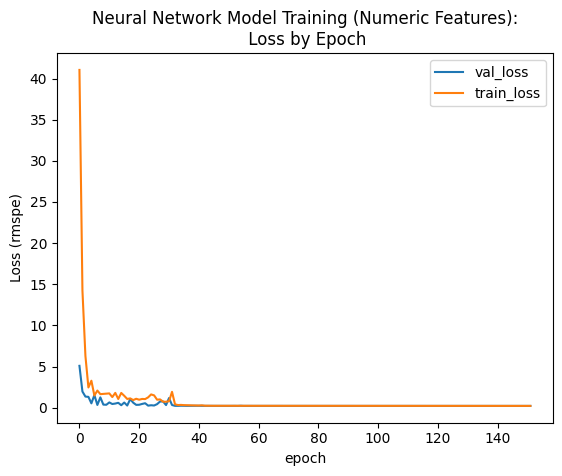

In [41]:
plt.plot(history2.history['val_loss'], label='val_loss')
plt.plot(history2.history['loss'], label='train_loss')
plt.xlabel('epoch')
plt.ylabel('Loss (rmspe)')
plt.title('Neural Network Model Training (Numeric Features):\n Loss by Epoch')
plt.legend()
plt.show()

### 3.4 Neural Network Model - numeric & categorical features

In [10]:

#clusters as categorical feature

X_clusters = all_features[['cluster_realized_vol_wap1', 'cluster_realized_vol_wap1_H2']]


In [11]:

set_seed_and_configure_tf_session(5376)

#model architecture - build an embedding layer for clusters

def emb_sz_rule(n_cat):
    return min(600, round(1.6* n_cat**0.56))

numeric_inputs = Input((X.shape[1],), name="numeric_inputs")
cluster_inputs = Input((2,), name="cluster_inputs")

embedding_layer1 = Embedding(5, emb_sz_rule(5), input_length=2, name='Embedding_layer_clusters')

cluster_inputs_transformed = embedding_layer1(cluster_inputs)
cluster_inputs_transformed = Flatten()(cluster_inputs_transformed)

inp = Concatenate()([cluster_inputs_transformed, numeric_inputs])
inp = Dense(200, activation=LeakyReLU(alpha=0.5))(inp)
inp = Dense(200, activation=LeakyReLU(alpha=0.3))(inp)
inp = Dense(100, activation=LeakyReLU(alpha=0.3))(inp)
out = Dense(1, name='output')(inp)

model5 = Model(inputs = [cluster_inputs, numeric_inputs], outputs=out, name="model_with_clusters_")
model5.compile(optimizer='adam', loss = keras_rmspe)
model5.summary()


Model: "model_with_clusters_"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cluster_inputs (InputLayer)    [(None, 2)]          0           []                               
                                                                                                  
 Embedding_layer_clusters (Embe  (None, 2, 4)        20          ['cluster_inputs[0][0]']         
 dding)                                                                                           
                                                                                                  
 flatten (Flatten)              (None, 8)            0           ['Embedding_layer_clusters[0][0]'
                                                                 ]                                
                                                                               

In [90]:
early_stopping_monitor = EarlyStopping(patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=8, min_lr=0.000001)
save_best = ModelCheckpoint('../WIP_data/preprocess_new/best_nn_model_num_and_2cat_3layer_200x2_100x1_lrelu.hdf5', \
                            save_best_only=True, save_weight_only=True)

history5 = model5.fit([X_clusters, X], y, validation_split = 0.2, epochs= 500, \
                      batch_size=128, callbacks=[early_stopping_monitor, reduce_lr, save_best])


Epoch 1/500
2050/2050 [==============================] - 19s 9ms/step - loss: 26.6537 - val_loss: 1.5684 - lr: 0.0010
Epoch 2/500
2050/2050 [==============================] - 17s 8ms/step - loss: 11.1251 - val_loss: 1.2380 - lr: 0.0010
Epoch 3/500
2050/2050 [==============================] - 17s 8ms/step - loss: 5.3169 - val_loss: 0.9405 - lr: 0.0010
Epoch 4/500
2050/2050 [==============================] - 17s 8ms/step - loss: 2.7035 - val_loss: 0.9844 - lr: 0.0010
Epoch 5/500
2050/2050 [==============================] - 17s 8ms/step - loss: 2.1172 - val_loss: 0.5253 - lr: 0.0010
Epoch 6/500
2050/2050 [==============================] - 17s 8ms/step - loss: 1.1739 - val_loss: 1.3383 - lr: 0.0010
Epoch 7/500
2050/2050 [==============================] - 17s 8ms/step - loss: 1.3912 - val_loss: 0.2642 - lr: 0.0010
Epoch 8/500
2050/2050 [==============================] - 17s 8ms/step - loss: 0.8499 - val_loss: 0.4128 - lr: 0.0010
Epoch 9/500
2050/2050 [==============================] - 17s 8

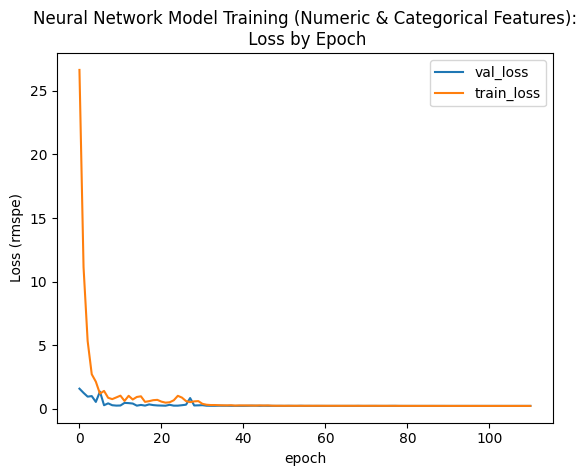

In [76]:
plt.plot(history5.history['val_loss'], label='val_loss')
plt.plot(history5.history['loss'], label='train_loss')
plt.xlabel('epoch')
plt.ylabel('Loss (rmspe)')
plt.title('Neural Network Model Training (Numeric & Categorical Features):\n Loss by Epoch')
plt.legend()
plt.show()

In [75]:
model5.save_weights("../WIP_data/preprocess_new/nn_model_num_and_2cat_200x2_100x1_lrelu_final_weights.hdf5")


### 3.5 Light GBM Model

In [123]:
all_features = all_features.dropna(how='any')
X_lgb = all_features.drop(columns = ['time_id','target', 'row_id'])
y_lgb = all_features['target']
X_lgb.shape, y_lgb.shape

((327942, 182), (327942,))

In [127]:
## Model based on LightGBM

seed = 5376
np.random.seed(seed)

def lgb_rmspe(preds, eval_data):
    #custom evaluation function for lgb model
    y_true = eval_data.get_label()
    
    return 'rmspe', rmspe(y_true, preds), False

params = {'learning_rate': 0.01, 'feature_fraction': 0.6, 'feature_fraction_bynode': 0.7, 'min_data_in_leaf': 200,
          'max_depth': 5, 'seed': seed, 'feature_fraction_seed': seed, 'objective': 'rmse',
            'boosting': 'gbdt', 'verbosity': -1, 'n_jobs': -1}   

X_train, X_test, y_train, y_test = train_test_split(X_lgb, y_lgb, test_size=0.2, random_state = seed)
cat_features = ['stock_id', 'cluster_realized_vol_wap1', 'cluster_realized_vol_wap1_H2']

lgb_train = lgb.Dataset(X_train, y_train, categorical_feature = cat_features)
lgb_test = lgb.Dataset(X_test, y_test, categorical_feature = cat_features)

model = lgb.train(params = params, train_set = lgb_train, valid_sets = [lgb_train, lgb_test], num_boost_round = 5000, \
                  early_stopping_rounds = 200, verbose_eval = 200, feval = lgb_rmspe)
    

Training until validation scores don't improve for 200 rounds
[200]	training's l2: 1.66878e-06	training's rmspe: 0.327415	valid_1's l2: 1.63249e-06	valid_1's rmspe: 0.32612
[400]	training's l2: 1.41094e-06	training's rmspe: 0.262275	valid_1's l2: 1.40418e-06	valid_1's rmspe: 0.258338
[600]	training's l2: 1.34857e-06	training's rmspe: 0.254489	valid_1's l2: 1.36433e-06	valid_1's rmspe: 0.251032
[800]	training's l2: 1.30943e-06	training's rmspe: 0.251658	valid_1's l2: 1.34486e-06	valid_1's rmspe: 0.2486
[1000]	training's l2: 1.27794e-06	training's rmspe: 0.249779	valid_1's l2: 1.33055e-06	valid_1's rmspe: 0.247105
[1200]	training's l2: 1.24965e-06	training's rmspe: 0.248166	valid_1's l2: 1.31826e-06	valid_1's rmspe: 0.245859
[1400]	training's l2: 1.22574e-06	training's rmspe: 0.24632	valid_1's l2: 1.30862e-06	valid_1's rmspe: 0.244539
[1600]	training's l2: 1.20475e-06	training's rmspe: 0.245249	valid_1's l2: 1.30167e-06	valid_1's rmspe: 0.243847
[1800]	training's l2: 1.18519e-06	training

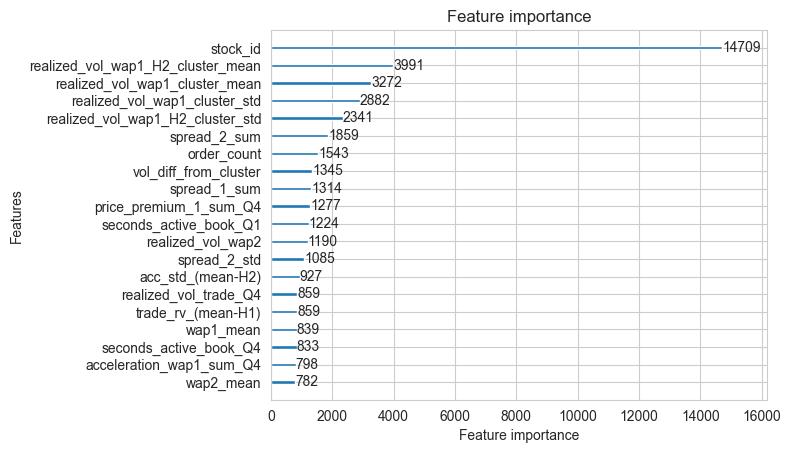

In [128]:
lgb.plot_importance(model, max_num_features=20)
plt.show()

### 3.6 Making Predictions on test set using best model

During model buiilding and training, the **neural network model based on numerical and categorical (stock clusters)** features performed the best. 

Let's evaluate the performance on this neural network models on the test set.


In [6]:
all_features_test = pd.read_csv('../WIP_data/preprocess_new/all_stocks_test_set_.csv')
all_features_test.head()

stock_id  time_id  wap1_mean  wap1_std  wap1_hl_index  wap2_mean  wap2_std  \
0         0    147.0   0.999258  0.000643       1.002478   0.999355  0.000793   
1         0    159.0   1.000076  0.001389       1.005497   1.000132  0.001441   
2         0    227.0   0.998649  0.000934       1.003511   0.998669  0.000998   
3         0    254.0   0.995034  0.002407       1.010356   0.994984  0.002623   
4         0    310.0   1.010786  0.001924       1.007194   1.011137  0.002082   

   wap2_hl_index  wap_diff_mean  wap_diff_std  ...  \
0       1.002843      -0.000097      0.000381  ...   
1       1.005658      -0.000057      0.000320  ...   
2       1.003844      -0.000020      0.000491  ...   
3       1.010221       0.000050      0.001332  ...   
4       1.009292      -0.000351      0.001312  ...   

   realized_vol_wap1_H2_cluster_std  vol_diff_from_cluster  estimate1  \
0                          0.000353               0.000448   0.003084   
1                          0.000468              -0.000114   0.003570   
2                          0.001010               0.000325   0.004734   
3                          0.002075               0.004266   0.011428   
4                          0.001807               0.004359   0.010097   

   estimate2  estimate3  estimate4  estimate5  estimate6  estimate7  estimate8  
0   0.002589   0.002961   0.002847   0.002842   0.002821   0.002829   0.003061  
1   0.002738   0.003362   0.003181   0.003168   0.003141   0.003147   0.003097  
2   0.006384   0.005147   0.005620   0.005590   0.005430   0.005495   0.005722  
3   0.008697   0.010745   0.010154   0.010108   0.010032   0.010047   0.012195  
4   0.010414   0.010176   0.010257   0.010256   0.010113   0.010184   0.012435  

[5 rows x 185 columns]

In [13]:
no_of_time_ids = all_features_test['time_id'].nunique()
no_of_time_ids

766

In [14]:

start_time = time.time()

with open('../WIP_data/preprocess_new/nn_feature_scaler.pkl', 'rb') as file:
    scaler_test = pickle.load(file)

all_features_test = all_features_test.dropna(how='any')
y_test = all_features_test['target'].to_numpy()
X_test = all_features_test.drop(columns = ['stock_id','time_id','target', 'row_id', 
                                           'cluster_realized_vol_wap1', 'cluster_realized_vol_wap1_H2'])
X_test = scaler_test.transform(X_test)
X_test_cluster = all_features_test[['cluster_realized_vol_wap1', 'cluster_realized_vol_wap1_H2']]

model_replica3 = Model(inputs = [cluster_inputs, numeric_inputs], outputs=out, name="model_replica_with_clusters_")
model_replica3.load_weights('../WIP_data/preprocess_new/best_nn_model_num_and_2cat_3layer_200x2_100x1_lrelu.hdf5')
model_replica3.compile(optimizer = 'adam', loss = keras_rmspe)

results3 = model_replica3.evaluate([X_test_cluster, X_test] , y_test)

end_time = time.time()
time_taken_per_time_id = (end_time - start_time) / no_of_time_ids

print("Evaluation: Neural network model based on numerical and categorical features\n")
print("\nRMSPE loss on test set: ", results3)
print(f"Avg. computation time per time_id for all 112 stocks: {time_taken_per_time_id} seconds")


2561/2561 [==============================] - 11s 2ms/step - loss: 0.2154
Evaluation: Neural network model based on numerical and categorical features


RMSPE loss on test set:  0.21536540985107422
\Avg. computation time per time_id for all 112 stocks: 0.018213899888818007 seconds


In [20]:
start_time = time.time()

model_replica2 = get_model_lrelu(179, [200,200,100], alphas=[0.5,0.3,0.3])
model_replica2.load_weights('../WIP_data/preprocess_new/best_nn_model_only_numerical_3layer_200x2_100x1_lrelu.hdf5')
model_replica2.compile(optimizer = 'adam', loss = keras_rmspe)
results2 = model_replica2.evaluate(X_test, y_test)

end_time = time.time()

time_taken_per_time_id = (end_time - start_time) / no_of_time_ids

print("\nEvaluation: Neural network model based on numerical features")
print("\nRMSPE loss on test set: ", results2)
print(f"Avg. computation time per time_id for all 112 stocks: {time_taken_per_time_id} seconds")



2561/2561 [==============================] - 4s 2ms/step - loss: 0.2170

Evaluation: Neural network model based on numerical features

RMSPE loss on test set:  0.21700672805309296
Avg. computation time per time_id for all 112 stocks: 0.006592690789045927 seconds


# Conclusions

* The training dataset was preprocessed to generate features from book and trade data. In addition, cluster features and some estimator features were generated.
* 4 different models were trained :
        * Linear model based on numeric features 
        * Neural network model based on numeric features only
        * Neural network model based on numeric and catgorical features(stock clusters)
        * Light GBM model
        
* The neural network model based on numeric and catgorical features performed the best, with rmspe loss on validation set of **0.2104**.

* This model was used to predict target for the test set. The rmspe loss on test set was **0.215365**. 
